# Analysis code for _Intensional Gaps_
# TODO: modify this cell for details about new finite+nonfinite analysis

[Aaron Steven White](http://aaronstevenwhite.io)<br/>
*University of Rochester*<br/>
aaron.white@rochester.edu<br/>
*Last updated*: 8 May 2021

This notebook contains all of the analyses from:

> Kane, Benjamin, William Gantt, and Aaron Steven White. 2021. [Intensional gaps: Relating doxasticity, bouleticity, veridicality, factivity, and neg-raising](https://ling.auf.net/lingbuzz/005930/current.pdf). Accepted to _Semantics and Linguistic Theory_ 31.

If you use any of the code found in this directory, please cite that paper as well as [this repository](https://github.com/MegaAttitude/intensional-gaps.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3 (Validating a templatic approach)](#Validating-a-templatic-approach)
- [Section 4 (Lexicon-scale data collection)](#Lexicon-scale-data-collection)
- [Section 5 (Discovering inference patterns)](#Discovering-inference-patterns)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:r-4.2.3

RUN pip install pyro-ppl==1.8.4 &&\
    R -e "install.packages(c('tidyverse', 'lme4', 'glmmTMB', 'ggrepel'), repos = 'https://cloud.r-project.org')"
```

To run the jupyter notebook server, use:

```bash
docker run -it --rm --user $(id -u):$(id -g) --group-add users -v "$(pwd)":/home/jovyan -p 8888:8888 --name intensional-gaps intensional-gaps
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [1]:
# base libraries
import os
import re
import json

from typing import List, Optional
from warnings import warn
from dataclasses import dataclass
from collections import defaultdict

# numerical computing libraries
import numpy as np
import scipy.stats
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import DataLoader

from numpy.linalg import inv
from numpy import logaddexp
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import spearmanr

# mixture model
import pyro
import pyro.distributions as pdist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide.initialization import init_to_uniform
from pyro.infer import MCMC, NUTS

# regression, cross-validation, and PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# plotting libraries
import seaborn as sns
import rpy2
%load_ext rpy2.ipython

All the data needed for the analyses in this notebook are downloaded at run time, so an internet connection is also required.

In [2]:
!mkdir -p data
!mkdir -p plots

In cases where values on $[0, 1]$ must be clipped to $(0, 1)$—e.g. for models that use the Beta distribution—we use the following values.

In [3]:
ZERO = 1e-5
ONE = 1 - ZERO
INF = 1e38

## Validating a templatic approach

Section 3 of the paper presents a study validating the use of our proposed templatic bleaching method. This study has two components: a norming study and a validation study.

### Norming study

The norming study aims to measure the prior probability that a particular generic belief or desire holds among entities under a description.

In [4]:
project_href = "http://megaattitude.io/projects/mega-intensionality/"
norming_href = project_href + "mega-intensionality-norming-v1/mega-intensionality-norming-v1.tsv"

norming = pd.read_csv(norming_href, sep='\t')

norming

,listid,participant,verb,subject,consequent,valence,question,response
0,0,96,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.00
1,0,33,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.00
2,0,2,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.17
3,0,59,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.10
4,0,29,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.06
...,...,...,...,...,...,...,...,...
4795,1,92,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,1.00
4796,1,97,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,0.81
4797,1,10,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,0.88
4798,1,48,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,0.23


The items are designed to induce bimodality in responses to the desire items, which we observe.

In [5]:
def bootstrap_mean(x, iters=999):
    bootstrapped_means = [np.mean(np.random.choice(x, size=x.shape[0])) for _ in range(iters)]
    return np.quantile(bootstrapped_means, [0.025, 0.5, 0.975])

id_vars = ['verb', 'subject', 'valence', 'consequent']

norming_mean = norming.groupby(id_vars).response.apply(bootstrap_mean).reset_index()

norming_mean['cilo'] = norming_mean.response.map(lambda x: x[0])
norming_mean['med'] = norming_mean.response.map(lambda x: x[1])
norming_mean['cihi'] = norming_mean.response.map(lambda x: x[2])

norming_mean = norming_mean.drop(columns='response')

norming_mean

,verb,subject,valence,consequent,cilo,med,cihi
0,apologize,child,positive,believe,0.78318,0.8324,0.87600
1,apologize,child,positive,want,0.95598,0.9788,0.99480
2,apologize,clerk,negative,believe,0.18240,0.2516,0.34484
3,apologize,clerk,negative,want,0.03358,0.0988,0.17842
4,apologize,teacher,positive,believe,0.71998,0.7864,0.84800
...,...,...,...,...,...,...,...
187,worry,guitarist,positive,want,0.92080,0.9600,0.98480
188,worry,journalist,negative,believe,0.17680,0.2308,0.29522
189,worry,journalist,negative,want,0.00760,0.0224,0.04160
190,worry,waiter,negative,believe,0.14360,0.1868,0.23080


More generally, we succeed in inducing high variability in the judgments for both _belief_ and _want_ items, which can be seen in Figure 1 of the paper (plotted below).

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


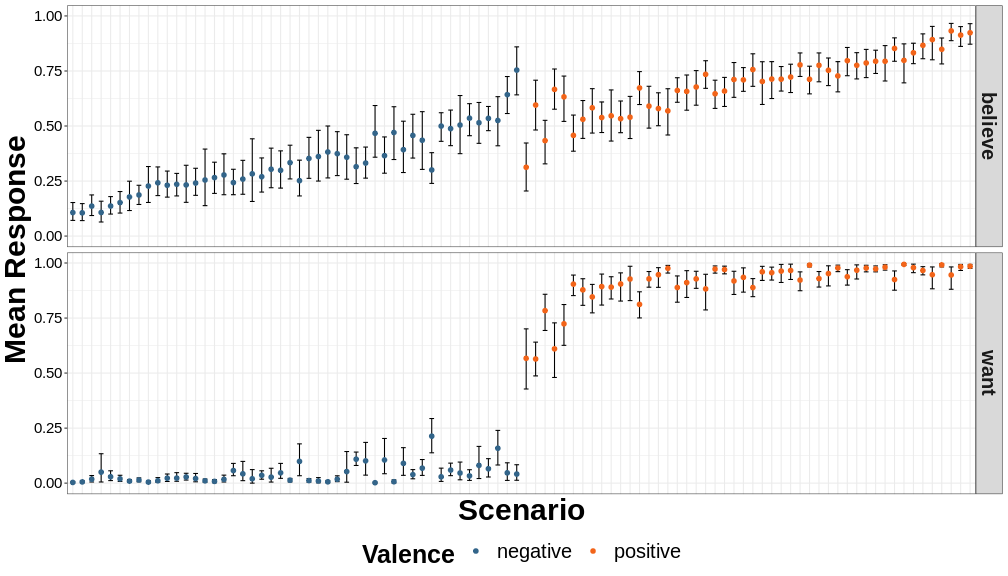

In [6]:
%%R -i norming_mean -w 14 -h 8 -u in

library(tidyverse)

theme_set(theme_bw())

norming_mean$item = interaction(norming_mean$subject, 
                                norming_mean$verb, 
                                norming_mean$valence)

g <- ggplot(norming_mean, aes(x=fct_reorder(item, med), y=med, ymax=cihi, ymin=cilo, color=valence)) + 
     geom_errorbar(color="black", width=0.5) + 
     geom_point(size=2) +
     facet_grid(consequent~.) +
     scale_color_manual(name='Valence', values=c("#33658a", "#f26419")) +
     xlab('Scenario') +
     ylab('Mean Response') +
     theme(axis.ticks.x=element_blank(),
           axis.text.x=element_blank(),
           strip.text=element_text(face="bold", size=20),
           axis.title=element_text(face="bold", size=30),
           axis.text.y=element_text(size=15, color="black"),
           legend.position="bottom",
           legend.title=element_text(face="bold", size=25),
           legend.text=element_text(size=20))

ggsave('plots/norming_means.png', width=14, height=8)
ggsave('plots/norming_means.pdf', width=14, height=8)

g

To obtain a single score for each item that adjusts for annotator differences in scale use, we fit a mixed effects beta regression to the responses, then use this model to predict a judgment for each item, setting the participant random effects to 0 and the predicate random effects to their best linear unbiased predictors. These predictions can be thought of as those that the "average" participant would give. 

Prior to fitting the model, we clip the responses because beta regression cannot handle 0s and 1s. (An alternative is to use 0-1 inflated beta regression, but we do not believe the extra complexity is warranted for current purposes.)

In [7]:
norming['response_clipped'] = norming.response.clip(ZERO, ONE)

In [8]:
%%R -i norming

library(glmmTMB)

set.seed(403928)

norming$item = interaction(norming$verb, norming$subject)

norming$consequent = relevel(as.factor(norming$consequent), 'want')
norming$valence = relevel(as.factor(norming$valence), 'positive')

contrasts(norming$valence) = contr.sum(levels(norming$valence))

m.norming = glmmTMB(response_clipped ~ consequent*valence + (1+consequent|item) + (1+consequent*valence|participant),
                    data=norming, family=list(family="beta",link="logit"))

We set the participant random effects to 0 (by changing all of the participants identifiers to one that does not exist in the data. The best linear unbiased predictors for the predicate random effects are used by `predict` by default.

In [9]:
%%R -o norming_normalized

norming$participant = max(norming$participant) + 1

norming$response_normalized = predict(m.norming, norming, allow.new.levels=TRUE)

norming_normalized = norming %>% 
                     group_by(consequent, valence, verb, subject) %>%
                     summarise(norm=mean(response_normalized))  

norming_normalized

`summarise()` has grouped output by 'consequent', 'valence', 'verb'. You can
override using the `.groups` argument.
# A tibble: 192 × 5
# Groups:   consequent, valence, verb [96]
   consequent valence  verb         subject       norm
   <fct>      <fct>    <chr>        <chr>        <dbl>
 1 want       positive apologize    child        2.69 
 2 want       positive apologize    teacher      2.53 
 3 want       positive boast        dancer       2.43 
 4 want       positive boast        fire fighter 2.72 
 5 want       positive complain     dishwasher   0.388
 6 want       positive complain     model        2.15 
 7 want       positive congratulate conductor    2.60 
 8 want       positive congratulate moderator    1.65 
 9 want       positive convince     concierge    2.03 
10 want       positive convince     therapist    2.35 
# ℹ 182 more rows
# ℹ Use `print(n = ...)` to see more rows


In [10]:
norming_normalized

,consequent,valence,verb,subject,norm
1,want,positive,apologize,child,2.685217
2,want,positive,apologize,teacher,2.528394
3,want,positive,boast,dancer,2.431845
4,want,positive,boast,fire fighter,2.723671
5,want,positive,complain,dishwasher,0.388026
...,...,...,...,...,...
188,believe,negative,think,doctor,0.174642
189,believe,negative,wish,politician,-0.857444
190,believe,negative,wish,salesman,-0.041308
191,believe,negative,worry,journalist,-0.946599


### Validation Study

The aim of the validation study is to ensure that gathering data using templatic items yields the same information about the inferential properties of the lexical items in the antecedents as an approach that uses contentful items and adjusts for world knowledge.

The responses to the templatic and contentful items are bundled together.

In [11]:
validation_href = project_href + 'mega-intensionality-validation-v1/mega-intensionality-validation-v1.tsv'

validation = pd.read_csv(validation_href, sep='\t')

validation['response_clipped'] = validation.response.clip(ZERO, ONE)

validation

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped
0,4,210,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000
1,4,319,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.88,0.88000
2,4,7,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.97,0.97000
3,4,259,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.81,0.81000
4,4,308,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,14,203,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,0.43,0.43000
15356,14,3,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,1.00,0.99999
15357,14,3,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999
15358,14,179,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999


The templatic items can be identified by a `"neutral"` label for `valence`.

In [12]:
validation_templatic = validation.query('valence == "neutral"')

validation_templatic

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped
7680,10,152,persuade,A,object,believe,negative,future,neutral,A didn't persuade B that C would happen.How li...,transitive,0.19,0.19000
7681,10,152,persuade,A,object,want,positive,future,neutral,A persuaded B that C would happen.How likely i...,transitive,0.42,0.42000
7682,10,262,persuade,A,object,believe,negative,future,neutral,A didn't persuade B that C would happen.How li...,transitive,0.26,0.26000
7683,10,262,persuade,A,object,want,positive,future,neutral,A persuaded B that C would happen.How likely i...,transitive,0.34,0.34000
7684,10,212,persuade,A,object,want,positive,future,neutral,A persuaded B that C would happen.How likely i...,transitive,0.50,0.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,14,203,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,0.43,0.43000
15356,14,3,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,1.00,0.99999
15357,14,3,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999
15358,14,179,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999


The contentful items can be identified by a non-`"neutral"` (`"positive"` or `"negative"`) label for `valence`.We merge these contentful judgments with the normalized norming scores in preparation for asking how well normalized templatic scores and normalized norming scores together predict the contentful judgments. 

In [13]:
validation_contentful = validation.query('valence != "neutral"')
validation_contentful = pd.merge(validation_contentful, norming_normalized)

validation_contentful

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped,norm
0,4,210,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000,2.447570
1,4,319,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.88,0.88000,2.447570
2,4,7,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.97,0.97000,2.447570
3,4,259,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.81,0.81000,2.447570
4,4,308,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000,2.447570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,16,36,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,1.00,0.99999,2.462086
7676,16,85,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,0.93,0.93000,2.462086
7677,16,141,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,0.86,0.86000,2.462086
7678,16,217,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,1.00,0.99999,2.462086


The distribution of responses for both templatic and contentful items are show in Figure 2 of the paper (plotted below).

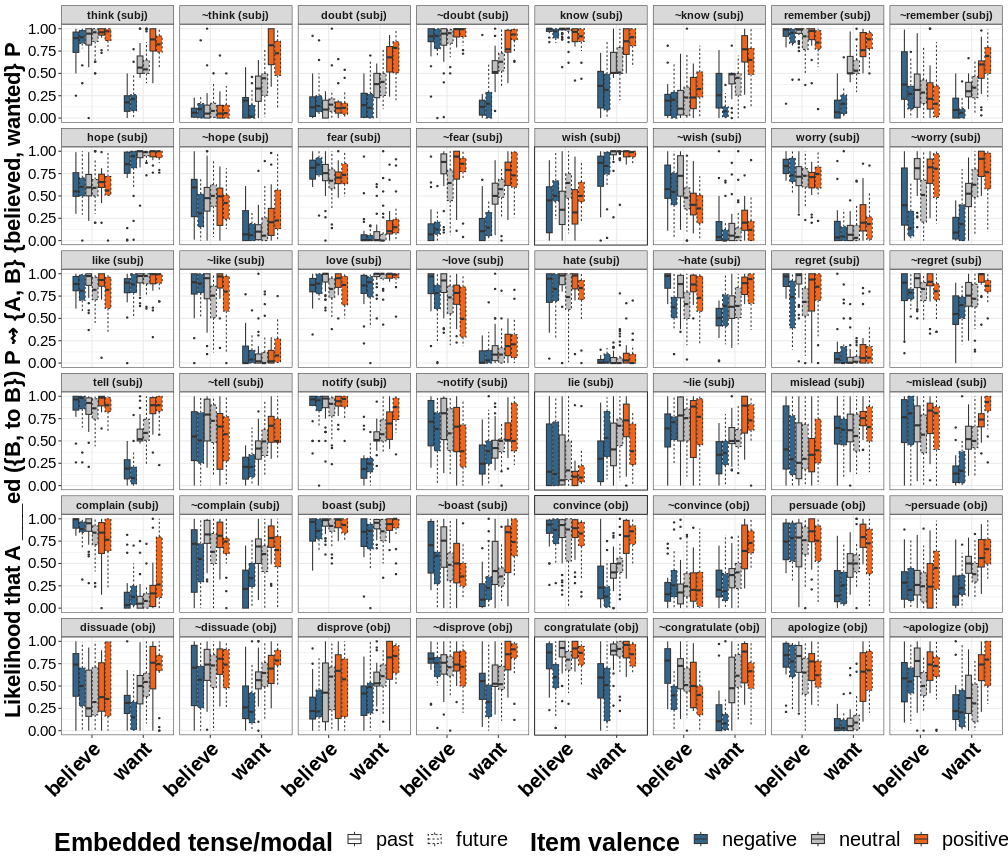

In [14]:
%%R -i validation -w 14 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

validation$target = ifelse(validation$target == 'subject', 'subj', 'obj')

validation$polarity_verb_target = paste0(ifelse(validation$polarity == 'negative', '~', ''), 
                                                 validation$verb, ' (', validation$target, ')')

ord = c("think (subj)" , "~think (subj)",
        "doubt (subj)", "~doubt (subj)",
        "know (subj)", "~know (subj)" ,       
        "remember (subj)", "~remember (subj)", 
        "hope (subj)", "~hope (subj)",
        "fear (subj)", "~fear (subj)",
        "wish (subj)", "~wish (subj)",
        "worry (subj)", "~worry (subj)",
        "like (subj)", "~like (subj)",
        "love (subj)", "~love (subj)",
        "hate (subj)", "~hate (subj)",
        "regret (subj)", "~regret (subj)",
        "tell (subj)", "~tell (subj)",
        "notify (subj)", "~notify (subj)",
        "lie (subj)", "~lie (subj)",
        "mislead (subj)", "~mislead (subj)",
        "complain (subj)", "~complain (subj)",
        "boast (subj)", "~boast (subj)",
        "convince (obj)", "~convince (obj)",
        "persuade (obj)", "~persuade (obj)",
        "dissuade (obj)", "~dissuade (obj)",
        "disprove (obj)", "~disprove (obj)",
        "congratulate (obj)", "~congratulate (obj)", 
        "apologize (obj)", "~apologize (obj)" )

validation$polarity_verb_target = ordered(validation$polarity_verb_target, 
                                                  levels=ord)

validation$tense = ordered(validation$tense, levels=c('past', 'future'))

g <- ggplot(validation, aes(x=consequent, y=response, fill=valence, linetype=tense)) + 
geom_boxplot(outlier.size=0.5) +
xlab('') +
ylab(paste0('Likelihood that A ___ed ({B, to B}) P ', sprintf('\u21DD'),' {A, B} {believed, wanted} P')) +
scale_fill_manual(name='Item valence', values=c("#33658a", "grey", "#f26419")) +
scale_linetype(name='Embedded tense/modal') +
facet_wrap(~polarity_verb_target, nrow=6) +
theme(strip.text=element_text(face="bold", size=11),
     axis.title.y=element_text(face="bold", size=22),
     axis.text.x=element_text(face="bold", size=20, angle=45, hjust=1, color="black"),
     axis.text.y=element_text(size=15, color="black"),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/validation_distributions.png', width=14, height=12)
ggsave('plots/validation_distributions.pdf', width=14, height=12)

g

To construct normalized scores for the templatic items, we fit a beta mixed effects model.

In [15]:
%%R -i validation_templatic

set.seed(403928)

validation_templatic$consequent = relevel(as.factor(validation_templatic$consequent), 'want')
validation_templatic$polarity = relevel(as.factor(validation_templatic$polarity), 'positive')
validation_templatic$tense = relevel(as.factor(validation_templatic$tense), 'future')

validation_templatic$target = as.factor(paste(validation_templatic$transitivity,
                                              validation_templatic$target, sep='-'))

contrasts(validation_templatic$polarity) = contr.sum(levels(validation_templatic$polarity))
contrasts(validation_templatic$tense) = contr.sum(levels(validation_templatic$tense))

m = glmmTMB(response_clipped ~ consequent*polarity*tense*target + (1+consequent*polarity*tense|verb) + (1+consequent*polarity*tense*target|participant),
            data=validation_templatic, family=list(family="beta",link="logit"))

Then, as for the norming data, we set the participant random effects to 0 (by changing all of the participants identifiers to one that does not exist in the data. The best linear unbiased predictors for the predicate random effects are used by `predict` by default.

In [16]:
%%R -o validation_templatic_normalized

validation_templatic$participant <- max(validation_templatic$participant) + 1

validation_templatic$response_normalized <- predict(m, validation_templatic, allow.new.levels=TRUE)

validation_templatic_normalized <- validation_templatic %>% 
                                   group_by(consequent, polarity, tense, verb) %>%
                                   summarise(neutral=mean(response_normalized))  

validation_templatic_normalized

`summarise()` has grouped output by 'consequent', 'polarity', 'tense'. You can
override using the `.groups` argument.
# A tibble: 192 × 5
# Groups:   consequent, polarity, tense [8]
   consequent polarity tense  verb         neutral
   <fct>      <fct>    <fct>  <chr>          <dbl>
 1 want       positive future apologize    -1.83  
 2 want       positive future boast         1.91  
 3 want       positive future complain     -2.09  
 4 want       positive future congratulate  1.93  
 5 want       positive future convince      0.0625
 6 want       positive future disprove      0.438 
 7 want       positive future dissuade      0.223 
 8 want       positive future doubt        -0.385 
 9 want       positive future fear         -2.45  
10 want       positive future hate         -2.75  
# ℹ 182 more rows
# ℹ Use `print(n = ...)` to see more rows


In [17]:
validation_templatic_normalized

,consequent,polarity,tense,verb,neutral
1,want,positive,future,apologize,-1.829837
2,want,positive,future,boast,1.907423
3,want,positive,future,complain,-2.088302
4,want,positive,future,congratulate,1.930851
5,want,positive,future,convince,0.062472
...,...,...,...,...,...
188,believe,negative,past,remember,-0.655837
189,believe,negative,past,tell,1.412823
190,believe,negative,past,think,-2.097481
191,believe,negative,past,wish,0.792324


We merge these scores with the contenful data.

In [18]:
validation_contentful_templatic = pd.merge(validation_contentful, validation_templatic_normalized)

validation_contentful_templatic

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped,norm,neutral
0,4,210,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90,2.447570,0.685902
1,4,319,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.88,0.88,2.447570,0.685902
2,4,7,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.97,0.97,2.447570,0.685902
3,4,259,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.81,0.81,2.447570,0.685902
4,4,308,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90,2.447570,0.685902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,19,51,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.55,0.55,-0.857444,-0.292493
7676,19,10,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.83,0.83,-0.857444,-0.292493
7677,19,13,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.14,0.14,-0.857444,-0.292493
7678,19,37,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.54,0.54,-0.857444,-0.292493


To assess how well responses to templatic items capture the same information about the inferential properties of the lexical items as an approach that uses contentful items and adjusts for world knowledge, we assess how well the judgments for contentful items can be predicted given just the normalized scores from the norming experiment and the judgments for the templatic items. 

In [19]:
%%R -i validation_contentful_templatic -o cv_corrs

set.seed(403928)

verb.order = unique(validation_contentful_templatic$verb)

mod.list = c()
verbs = c()
corrs = c()

for (v in verb.order) { 
    train = filter(validation_contentful_templatic, verb !=v)
    test = filter(validation_contentful_templatic, verb == v)
    
    m.norm.by.neutral <- glmmTMB(response_clipped ~ norm*neutral + (1+norm*neutral|verb) + (1+norm*neutral|participant),
                                   data=train, 
                                   family=list(family="beta",link="logit"))
    
    predicted = predict(m.norm.by.neutral, test, allow.new.levels=TRUE)
    spearman = cor(test$response_clipped, predicted, method="spearman")
    
    verbs = c(verbs, v)
    corrs = c(corrs, spearman)
    
    mod.list = c(mod.list, list(mod=m.norm.by.neutral, excluded=v, predicted=predicted))
}

cv_corrs = data.frame(verbs=verbs, corrs=corrs)

cv_corrs

          verbs     corrs
1          know 0.8624418
2      convince 0.7509370
3         boast 0.6949812
4  congratulate 0.6371445
5        notify 0.6934849
6      disprove 0.6086172
7          fear 0.6876209
8         doubt 0.8691338
9      complain 0.6437071
10         like 0.8056078
11         hope 0.7262836
12          lie 0.4985933
13       regret 0.7590106
14     remember 0.8223247
15        worry 0.6769383
16         tell 0.6992527
17     persuade 0.6703736
18    apologize 0.6110460
19        think 0.8684903
20         hate 0.8136546
21     dissuade 0.5035038
22      mislead 0.4421455
23         love 0.7951146
24         wish 0.7112734


The result is an average rank correlation of 0.70.

In [20]:
cv_corrs_stats = np.round(np.quantile([np.mean(np.random.choice(cv_corrs.corrs.values,
                                                                cv_corrs.corrs.values.shape[0])) 
                                       for _ in range(999)], 
                                      [0.025, 0.5, 0.975]), 2)

print('$\\\\rho$ = {}, (95\\%CI = [{}, {}])'.format(cv_corrs_stats[1], cv_corrs_stats[0], cv_corrs_stats[2]))

$\\rho$ = 0.7, (95\%CI = [0.66, 0.74])


This is reliably better than the interannotator agreement.

In [21]:
iaa_corrs = []

for listid, listdf in validation_contentful.groupby('listid'):
    parts = listdf.participant.unique()
    
    for p1 in parts:
        for p2 in parts:
            if p1 != p2:
                merged = pd.merge(listdf[listdf.participant==p1],
                                  listdf[listdf.participant==p2],
                                  on=[c for c in listdf.columns 
                                      if c not in ['participant', 'response', 
                                                   'response_clipped', 'norm']])
                #corr = np.corrcoef(merged.response_x, merged.response_y)[1,0]
                corr = spearmanr(merged.response_x, merged.response_y).correlation
                
                iaa_corrs.append([listid, p1, p2, corr])
    
iaa_corrs = pd.DataFrame(iaa_corrs, columns=['listid', 'participant1', 'participant2', 'correlation'])

iaa_stats = np.round(np.quantile([iaa_corrs.sample(frac=1., replace=True).correlation.mean() 
                                  for _ in range(999)], [0.025, 0.5, 0.975]), 2)

print('$\\\\rho$ = {}, (95\\%CI = [{}, {}])'.format(iaa_stats[1], iaa_stats[0], iaa_stats[2]))

$\\rho$ = 0.58, (95\%CI = [0.57, 0.59])


## Lexicon-scale data collection

We collect the MegaIntensionality dataset using the templatic methodology validated above.

In [22]:
bulk1_href = project_href  + 'mega-intensionality-v1/mega-intensionality-v1.tsv'
bulk2_href = 'data/mega-intensionality-nonfinite.tsv'

mc1 = pd.read_csv(bulk1_href, sep='\t')
mc1['participant'] = mc1['participant'].astype('str') + '_1'
mc2 = pd.read_csv(bulk2_href, sep='\t')
mc2['participant'] = mc2['participant'].astype('str') + '_2'

mc = pd.concat([mc1, mc2])
mc_cols = list(mc.columns)
mc_cols_reordered = mc_cols[0:mc_cols.index('target')] + ['target', 'control'] + mc_cols[mc_cols.index('target')+1:-1]
mc = mc[mc_cols_reordered]
mc['participant'] = mc['participant'].astype('category').cat.codes
mc['control'] = mc['control'].fillna('na')

mc

,participant,antecedent_verb,antecedent_polarity,target,control,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity
0,506,fess_up,negative,object,na,NP V to NP that S[+future],want,future,A didn't fess up to B that C would happen,B wanted C to happen,0.38,4
1,506,consider,positive,subject,na,NP V that S,want,past,A considered that C happened,A wanted C to have happened,0.78,4
2,506,traumatize,negative,subject,na,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67,4
3,506,speculate,positive,object,na,NP V to NP that S[+future],believe,future,A speculated to B that C would happen,B believed that C would happen,0.63,4
4,506,blare,positive,subject,na,NP V that S[-tense],want,future,A blared that C happen,A wanted C to happen,0.86,4
...,...,...,...,...,...,...,...,...,...,...,...,...
92635,335,cause,negative,subject,object,NP V NP to VP[+eventive],believe,future,A didn't cause B to do C.,How likely is it that A believed that B would ...,0.29,4
92636,335,perceive,positive,object,object,NP V NP to VP[+eventive],intend,future,A perceived B to do C.,How likely is it that B intended to do C?,0.50,4
92637,335,steer,negative,object,object,NP V NP to VP[+eventive],intend,future,A didn't steer B to do C.,How likely is it that B intended to do C?,0.50,4
92638,335,sign_on,positive,subject,subject,NP V to VP[+eventive],intend,future,A signed on to do C.,How likely is it that A intended to do C?,1.00,4


To visualize these data, we first derive an aggregate score using a beta mixed model-based normalizer.

In [23]:
def hash_column(col: pd.Series) -> np.array:
    col_as_cat = col.astype('category')
    
    values = torch.tensor(col_as_cat.cat.codes.values).type(torch.long)
    categories = col_as_cat.cat.categories
    
    return values, categories

class UnitNormalizer:
    
    required_columns = ['item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, seed: int = 42):
        self._seed = seed
    
    def _validate_data(self, data: pd.DataFrame) -> None:
        for col in self.required_columns:
            if col not in data.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
                
    def _prepare_data(self, data: pd.DataFrame) -> None:
        self._raw_data = data
        
        self._validate_data(data)

        for col in self.required_columns:
            if col == 'response':
                setattr(self, col, torch.tensor(data[col].values).type(torch.float))
                setattr(self, f'n_{col}', data.shape[0])

            else:
                values, categories = hash_column(data[col])
                setattr(self, col, values)
                setattr(self, f'{col}_categories', categories)
                setattr(self, f'n_{col}', len(categories))
    
    def _init_loc_fn(self, site):        
        return init_to_uniform(site, radius=1e-3)
    
    def _initialize_model(self):
        
        def model(item, participant, response):
            scale = pyro.sample('scale', pdist.Normal(0., self.large_variance))
            
            # Vector of variances for each of the d variables
            theta = pyro.sample("theta", pdist.HalfCauchy(torch.ones(2)).to_event(1))
            # Lower cholesky factor of a correlation matrix
            L_omega = pyro.sample("L_omega", pdist.LKJCorrCholesky(2, 1.0))
            # Lower cholesky factor of the covariance matrix
            participant_scale = torch.mm(theta.sqrt().diag_embed(), L_omega)
            
            with pyro.plate('item_plate', self.n_item):
                locs = pyro.sample('locs', pdist.Normal(0, self.large_variance))
            
            with pyro.plate('participant_plate', self.n_participant):
                locs_scales_participant = pyro.sample('locs_scales_participant',
                                                      pdist.MultivariateNormal(torch.zeros(2),
                                                                              scale_tril=participant_scale))

            with pyro.plate('response_plate', self.n_response):                
                locs = torch.sigmoid(locs[item] + locs_scales_participant[participant, 1])
                scales = torch.square(scale + locs_scales_participant[participant, 0])
                
                concentration1 = scales*locs
                concentration0 = scales*(1.-locs)

                pyro.sample('obs', 
                            pdist.Beta(concentration1.clamp(min=ZERO),
                                      concentration0.clamp(min=ZERO)), 
                            obs=response)
                
                lp = pdist.Beta(concentration1.clamp(min=ZERO), 
                               concentration0.clamp(min=ZERO)).log_prob(response)
                
                return lp
            
        guide = AutoDelta(model, init_loc_fn=self._init_loc_fn)
        
        return model, guide

    def fit(self, data: pd.DataFrame, lr: float = 0.05, tolerance=0.0005, window_size=100,
            iterations: int=1000, verbosity: int=10) -> 'UnitNormalizer':
        pyro.set_rng_seed(self._seed)
        pyro.clear_param_store()
        
        self._prepare_data(data)
        
        optim = pyro.optim.Adam({'lr': lr})
        self._elbo = Trace_ELBO(max_plate_nesting=1)
        
        self._model, self._guide = self._initialize_model()
        
        svi = SVI(self._model, self._guide, optim, loss=self._elbo)
        
        losses = []
         
        like_hist = []
        prev_like_sum = -np.inf
            
        for i in range(iterations):
            
            loss = svi.step(self.item, self.participant, self.response)
            losses.append(loss)
            
            if i and not i % verbosity:
                print('ELBO:', np.round(loss, 2))
        
        return self
    
    def param(self, param_name):
        return pyro.get_param_store()[f'AutoDelta.{param_name}']

In [24]:
mc['item'] = mc.antecedent_verb + '-' + mc.antecedent_polarity + '-' + mc.antecedent_frame + '-' +\
             mc.target + '-' + mc.control + '-' + mc.consequent_verb + '-' + mc.consequent_embedded_tense

mc['response'] = mc.response.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

normalizer = UnitNormalizer().fit(mc, iterations=50000, lr=0.1, verbosity=5000)

/opt/conda/lib/python3.10/site-packages/pyro/distributions/lkj.py:16: FutureWarning: class LKJCorrCholesky(d, eta, validate_args=None) is deprecated in favor of LKJCholesky(dim, concentration, validate_args=None).
  warnings.warn(


ELBO: -126181.41
ELBO: -126185.02
ELBO: -126176.15
ELBO: -126186.61
ELBO: -126180.13
ELBO: -126176.89
ELBO: -126182.25
ELBO: -126184.89
ELBO: -126185.5


The resulting normalized values are made available [here](http://megaattitude.io/projects/mega-intensionality/mega-intensionality-v1/mega-intensionality-v1-normalized.tsv).

In [25]:
keep_cols = ['item', 'antecedent_verb', 'antecedent_polarity', 'antecedent_frame', 
             'target', 'control', 'consequent_verb', 'consequent_embedded_tense', 'antecedent_text']

mc_normalized = pd.merge(mc[keep_cols].drop_duplicates().reset_index(drop=True),
                         pd.DataFrame(list(zip(normalizer.item_categories.values, 
                                               torch.sigmoid(normalizer.param('locs')).data.numpy())), 
                                      columns=['item', 'response_normalized']))

mc_normalized = mc_normalized.drop(columns='item')

mc_normalized.sort_values('response_normalized')

mc_normalized.to_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t', index=False)

Figure 3 in the paper plots these normalized values.

In [26]:
mc_normalized_cast = mc_normalized.pivot_table(index=['antecedent_verb', 
                                                      'antecedent_frame', 
                                                      'target',
                                                      'control',
                                                      'consequent_verb', 
                                                      'consequent_embedded_tense'],
                                              columns='antecedent_polarity',
                                              values='response_normalized').reset_index()

mc_normalized_cast_f = mc_normalized_cast[mc_normalized_cast['control'] == 'na']

mc_normalized_cast_nf = mc_normalized_cast[mc_normalized_cast['control'] != 'na']
mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']

mc_normalized_cast

/tmp/ipykernel_127/2875580870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']


antecedent_polarity,antecedent_verb,antecedent_frame,target,control,consequent_verb,consequent_embedded_tense,negative,positive
0,abhor,NP V VPing,subject,subject,believe,future,0.570749,0.265815
1,abhor,NP V VPing,subject,subject,believe,past,0.588805,0.385137
2,abhor,NP V VPing,subject,subject,intend,future,0.547927,0.157784
3,abhor,NP V VPing,subject,subject,intend,past,0.640675,0.343514
4,abhor,NP V VPing,subject,subject,want,future,0.705360,0.066379
...,...,...,...,...,...,...,...,...
10549,yelp,NP V to NP that S,subject,na,believe,past,0.580991,0.911396
10550,yelp,NP V to NP that S,subject,na,want,past,0.446453,0.507115
10551,yelp,NP V to VP[+eventive],subject,subject,believe,future,NaN,0.602164
10552,yelp,NP V to VP[+eventive],subject,subject,intend,future,0.469091,0.829669


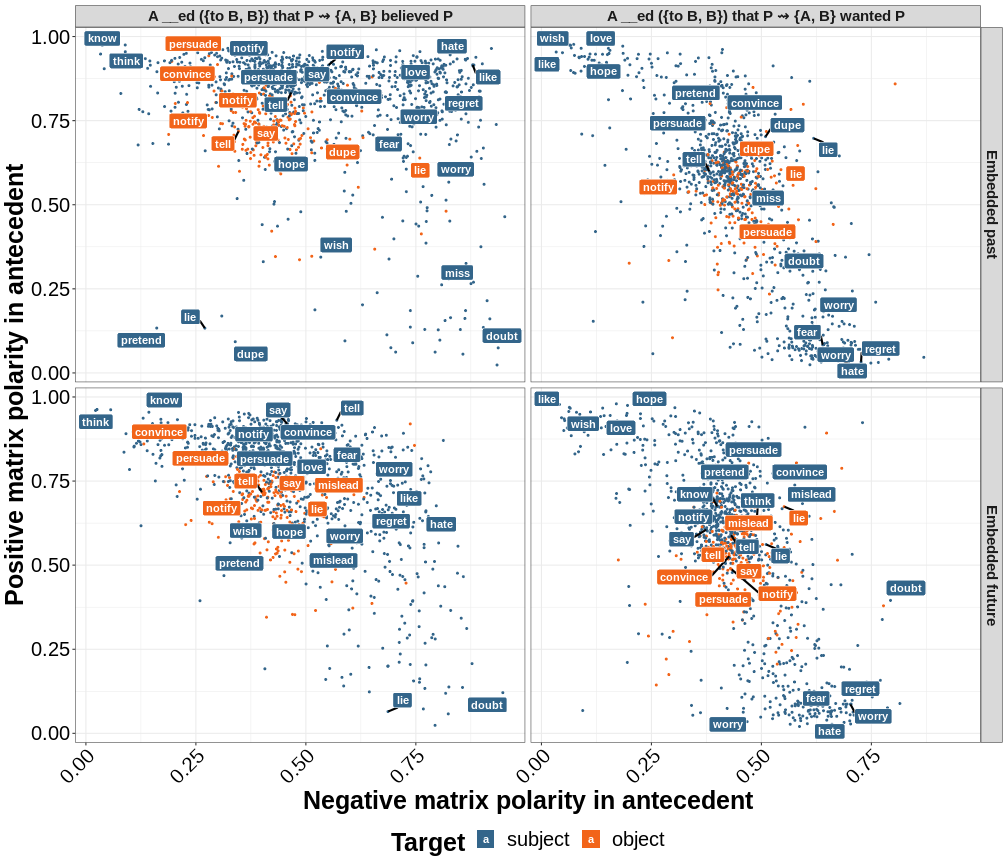

In [27]:
%%R -i mc_normalized_cast_f -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

mc_normalized_cast_f$target <- factor(mc_normalized_cast_f$target, levels=c('subject', 'object'))
mc_normalized_cast_f$consequent_embedded_tense <- factor(mc_normalized_cast_f$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_f = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss')
transitive_verbs_f = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe')

intransitive_frames_f = c('NP V that S', 'NP be V that S', 
                          'NP V that S[+future]', 'NP be V that S[+future]', 
                          'NP V that S[-tense]', 'NP be V that S[-tense]')
transitive_frames_f = c('NP V to NP that S', 'NP V NP that S',
                        'NP V to NP that S[+future]', 'NP V NP that S[+future]',
                        'NP V to NP that S[-tense]', 'NP V NP that S[-tense]')

g <- ggplot(mc_normalized_cast_f, aes(x=negative, y=positive, color=target)) +
geom_point(size=0.75) +
geom_label_repel(data=filter(mc_normalized_cast_f, 
                       (antecedent_verb%in%intransitive_verbs_f & antecedent_frame %in% intransitive_frames_f) | (antecedent_verb%in%transitive_verbs_f & antecedent_frame %in% transitive_frames_f)), 
           aes(label=antecedent_verb, fill=target), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target', values=c("#33658a", "#f26419")) +
scale_fill_manual(name='Target',  values=c("#33658a", "#f26419")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) that P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', 'wanted'), 
                            ifelse(consequent_verb=='believe', 'P', 'P'))) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_finite.png', width=14, height=12)
ggsave('plots/verb_distributions_finite.pdf', width=14, height=12)

g

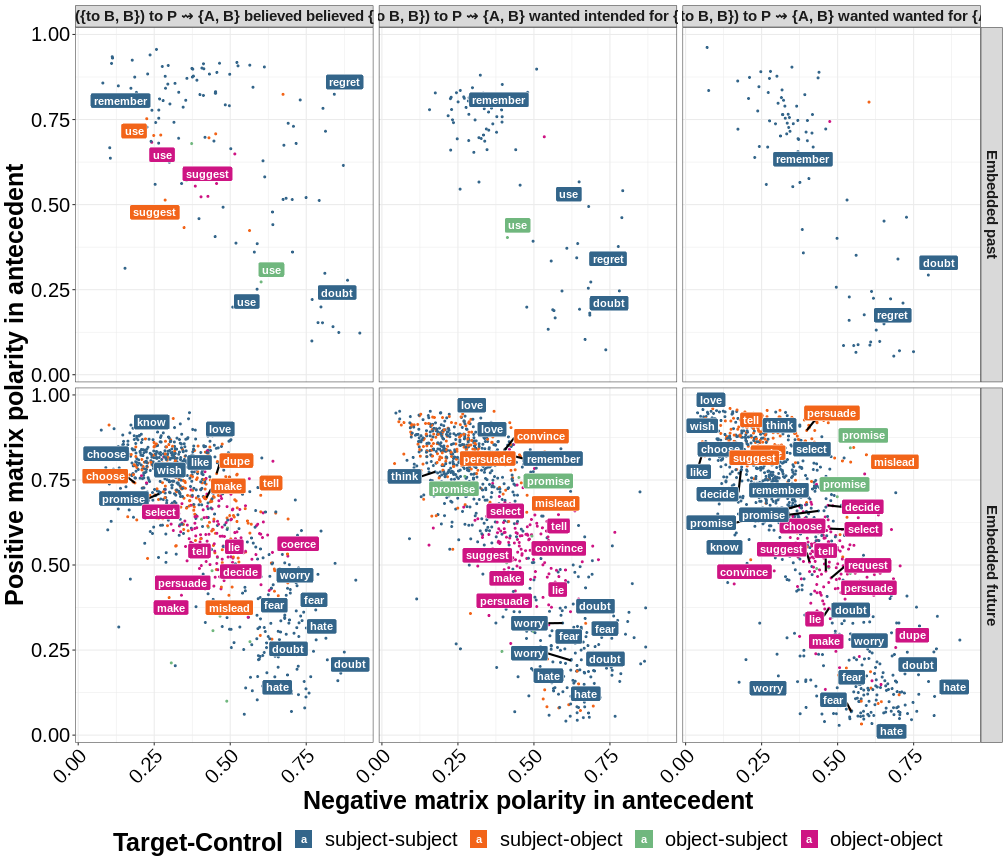

In [28]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, y=positive, color=target_control)) +
geom_point(size=0.75) +
geom_label_repel(data=filter(mc_normalized_cast_nf, 
                       (antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)), 
           aes(label=antecedent_verb, fill=target_control), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', 'wanted'), 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P')))) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_nonfinite.png', width=14, height=12)
ggsave('plots/verb_distributions_nonfinite.pdf', width=14, height=12)

g

## Discovering inference patterns

Section 5 in the paper applies a multiview mixed effects mixture model to MegaIntensionality as well as two other datasets simultaneously. For each dataset, we define a `verbframe` column, which gives the verb-frame pairs to be clustered, and an `item` column, which gives the dimensions of the cluster centers.

In [29]:
mc['verbframe'] = mc.antecedent_verb + '-' + mc.antecedent_frame

mc['item'] = (mc.antecedent_polarity + '-' +
              mc.target + '-' +
              mc.control + '-' +
              mc.consequent_verb)

In addition to MegaIntensionality, we use [MegaVeridicality](http://megaattitude.io/projects/mega-veridicality/), which captures veridicality inferences using 3-way ordinal judgments (_yes_, _maybe or maybe not_, _no_)...

In [30]:
mv = pd.read_csv('http://megaattitude.io/projects/mega-veridicality/mega-veridicality-v2/mega-veridicality-v2.csv')

mv = mv[mv.veridicality.notna()]
mv = mv[mv.nativeenglish]
mv = mv[~mv.conditional]

mv['frame'] = mv.frame + '-' + mv.voice
mv['frame'] = mv.frame.map({'that_S-active': 'NP V that S',
                            'that_S-passive': 'NP be V that S',
                            'to_VPeventive-active': 'NP V to VP[+eventive]',
                            'NP_to_VPeventive-active': 'NP V NP to VP[+eventive]',
                            'to_VPstative-active': 'NP V to VP[-eventive]',
                            'NP_to_VPstative-active': 'NP V NP to VP[-eventive]',
                            'to_VPeventive-passive': 'NP be V to VP[+eventive]',
                            'to_VPstative-passive': 'NP be V to VP[-eventive]',
                            'for_NP_to_VP-active': 'NP V for NP to VP'})

mv['verbframe'] = mv.verb + '-' + mv.frame

mv['item'] = mv.polarity

mv['response'] = mv.veridicality.astype(pd.CategoricalDtype(categories=['no', 'maybe', 'yes'])).cat.codes

mv

,participant,list,presentationorder,verb,frame,voice,polarity,conditional,sentence,veridicality,acceptability,nativeenglish,exclude,verbframe,item,response
0,487,0,1,surmise,NP V that S,active,positive,False,Someone surmised that a particular thing happened,maybe,6,True,False,surmise-NP V that S,positive,1
1,487,0,2,update,NP V that S,active,positive,False,Someone updated that a particular thing happened,yes,2,True,False,update-NP V that S,positive,2
2,487,0,3,disregard,NP V that S,active,negative,False,Someone didn\'t disregard that a particular th...,maybe,4,True,False,disregard-NP V that S,negative,1
3,487,0,4,agree,NP V that S,active,positive,False,Someone agreed that a particular thing happened,yes,4,True,False,agree-NP V that S,positive,2
4,487,0,5,surmise,NP V that S,active,negative,False,Someone didn\'t surmise that a particular thin...,maybe,3,True,False,surmise-NP V that S,negative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50255,127,81,53,compel,NP V NP to VP[-eventive],active,negative,False,Someone didn\'t compel a particular person to ...,maybe,5,True,False,compel-NP V NP to VP[-eventive],negative,1
50256,127,81,54,decline,NP V to VP[-eventive],active,negative,False,A particular person didn\'t decline to have a ...,yes,6,True,False,decline-NP V to VP[-eventive],negative,2
50257,127,81,55,advise,NP V NP to VP[+eventive],active,positive,False,Someone advised a particular person to do a pa...,maybe,7,True,False,advise-NP V NP to VP[+eventive],positive,1
50258,127,81,56,approve,NP be V to VP[-eventive],passive,positive,False,A particular person was approved to have a par...,yes,7,True,False,approve-NP be V to VP[-eventive],positive,2


...and [MegaNegRaising](http://megaattitude.io/projects/mega-negraising), which captures neg-raising inferences using a [0, 1] slider (like MegaIntensionality).

In [31]:
mn = pd.read_csv('http://megaattitude.io/projects/mega-negraising/mega-negraising-v1/mega-negraising-v1.tsv', sep='\t')

mn = mn[mn.nativeenglish]

mn['verbframe'] = mn.verb + '-' + mn.frame

mn['item'] = mn.subject + '-' + mn.tense

mn['response'] = mn.negraising.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

mn

,participant,list,presentationorder,verb,frame,tense,subject,sentence1,sentence2,negraising,acceptability,nativeenglish,verbframe,item,response
0,229,81,8,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.30,0.97,True,abhor-NP V that S,first-past,0.30000
1,259,81,15,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.09,0.34,True,abhor-NP V that S,first-past,0.09000
2,883,81,14,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.50,0.71,True,abhor-NP V that S,first-past,0.50000
3,665,81,22,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.00,0.87,True,abhor-NP V that S,first-past,0.00001
4,901,81,12,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.33,0.61,True,abhor-NP V that S,first-past,0.33000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79355,723,45,9,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.23,0.35,True,yelp-NP V to VP[+eventive],third-past,0.23000
79356,416,45,2,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.26,0.00,True,yelp-NP V to VP[+eventive],third-past,0.26000
79357,314,45,30,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.25,0.41,True,yelp-NP V to VP[+eventive],third-past,0.25000
79358,939,45,32,yelp,NP V to VP[+eventive],past,third,A particular person didn't yelp to do a partic...,That person yelped not to do that thing.,0.82,0.77,True,yelp-NP V to VP[+eventive],third-past,0.82000


### Combining the datasets

To make passing multiple datasets (with metadata) to the mixture model we define below, we use a lightweight dataclass.

In [32]:
@dataclass
class Data:
    dataframe: pd.DataFrame
    name: str
    datatype: str
        
data = [Data(mc, 'belief_desire', 'unit'), 
        Data(mv, 'veridicality', 'ordinal'),
        Data(mn, 'negraising', 'unit')]

### Multiview Mixed Effects Mixture Model

We define the multiview mixture model, which is initialized using a variant of $k$-means clustering that allows for missing data.

In [291]:
class KMeansWithMissingData:
    """K-Means for data with values missing
    
    Parameters
    ----------
    n_clusters
        The number of clusters.
    init
        How to initialize the model. Must be either "random" (default) 
        or "kmeans++".
    fuzzy_impute
        Whether to use hard (default) or fuzzy imputation when imputing 
        missing values during cluster center updates.
    random_state
        The random seed.
    """
    
    def __init__(self, n_clusters: int = 2, init: str="random", 
                 fuzzy_impute: bool = False, random_state: int = 42):
        self.n_clusters = n_clusters
        self.init_method = init
        self.fuzzy_impute = fuzzy_impute
        self.random_state = random_state
    
    def _initialize_cluster_centers(self):
        self.missing_patterns_, self.pattern_assignments_ = np.unique(self.missing_, 
                                                                      return_inverse=True,
                                                                      axis=0)
        self.observed_patterns_ = ~self.missing_patterns_
        
        self.X_binned_ = [self.X_[self.pattern_assignments_ == i] 
                          for i in range(self.missing_patterns_.shape[0])]
        
        X_synthesized = np.array([np.nanmean([b[np.random.choice(b.shape[0])]
                                              for b in self.X_binned_], axis=0) 
                                  for _ in range(self.X_.shape[0])])
        
        if self.init_method == "kmeans++":
            cluster_centers = np.array([X_synthesized[0]])

            for _ in range(self.n_clusters-1):
                dist = np.square(cluster_centers[:,None,:] -
                                 X_synthesized[None,:,:]).sum(axis=2)
                mindist = dist.min(axis=0)
                prob = mindist/mindist.sum()

                center = X_synthesized[np.random.choice(prob.shape[0], p=prob)]

                cluster_centers = np.concatenate([cluster_centers, [center]], axis=0)
                
        else:
            cluster_centers = X_synthesized[:self.n_clusters]

        self.cluster_centers_ = cluster_centers
    
    def _compute_cluster_assignments(self, X=None, cluster_centers=None):
        self.sqdist_to_center_ = self._compute_distances(X=X,
                                                         cluster_centers=cluster_centers)
        self.cluster_assignments_ = np.argmin(self.sqdist_to_center_, axis=0)
    
    def _compute_distances(self, X=None, cluster_centers=None):
        if X is None:
            X = self.X_
        
        if cluster_centers is None:
            cluster_centers = self.cluster_centers_
        
        return np.nansum(np.square(cluster_centers[:,None,:] - X[None,:,:]), 
                         axis=2)
    
    def _impute(self):
        if self.fuzzy_impute:
            weight = np.exp(-self.sqdist_to_center_)/\
                     np.exp(-self.sqdist_to_center_).sum(axis=0)[None,:]
            
            return np.where(self.missing_, 
                            np.sum(weight[:,:,None]*
                                   self.cluster_centers_[:,None,:], 
                                   axis=0), 
                            self.X_)
        else:
            return np.where(self.missing_, 
                            self.cluster_centers_[self.cluster_assignments_], 
                            self.X_)    
    
    def fit(self, X: np.array, maxiter=1000):
        """Computes a modified version of Lloyd's algorithm

        The main difference between the standard version of Lloyd's algorithm 
        and the one computed here is that, when computing the distance between 
        a point and a cluster center, only the observed values for the point 
        are used; and when updating cluster centers, the missing values for 
        a point are first imputed based either on the current cluster assignment 
        (hard imputation) or as a weighted mean over a softmax on the negative 
        distances.

        Parameters
        ----------
        X
            The points to cluster
        maxiter
            The maximum number of EM iterations
        """
        self.X_ = X
        self.n_samples_, self.n_features_ = self.X_.shape
        
        # find the missing values
        self.missing_ = np.isnan(self.X_)
        self.observed_ = ~self.missing_
        
        # initialize cluster centers
        np.random.seed(self.random_state)
        self._initialize_cluster_centers()
        
        # initialize cluster assignments
        self._compute_cluster_assignments()
        
        for _ in range(maxiter):
            previous_cluster_assignments = self.cluster_assignments_

            # impute missing values based on current assignments
            Ximputed = self._impute()
            
            # update cluster centers
            for i in np.arange(self.n_clusters):
                Ximputed_i = Ximputed[self.cluster_assignments_ == i]
                self.cluster_centers_[i] = np.mean(Ximputed_i, axis=0)
                
            # update cluster assignments
            self._compute_cluster_assignments()
            
            # test change in cluster assignments
            cluster_assignment_unchanged = (previous_cluster_assignments ==
                                            self.cluster_assignments_)

            if cluster_assignment_unchanged.all():
                break
            
        else:
            warn(f'KMeansWithMissingData({self.n_clusters}) did not converge'
                 f' after {maxiter} iterations')
        
        return self
    
    def distances(self, X):
        return self._compute_distances(X=X)
    
    def sse(self, X):
        agg = 0.
        distances = self.distances(X)
        assignments = self.cluster_assignments_
        for c in range(self.n_clusters):
            dc = distances[c][np.where(assignments == c)]
            agg += np.sum(np.square(dc))
        return agg
    
    
def compute_kmeans_best_fit(X: np.array, n_clusters: int = 2,
                            init: str="random", fuzzy_impute: bool = False, random_state: int = 42,
                            maxiter=1000, num_trials=1, verbosity=20):
    """Attempts to fit K-Means `num_trials` times, returning the result with the lowest squared error."""
    min_kmeans = None
    min_sse = np.inf
    np.random.seed(random_state)
    seeds = np.random.randint(0, 10000, size=num_trials)
    for trial in range(num_trials):
        if trial % verbosity == 0:
            print(f'Computing KMeans initialization with minimum squared error; current minimum: {min_sse}')
        kmeans = KMeansWithMissingData(n_clusters=n_clusters, init=init, fuzzy_impute=fuzzy_impute, random_state=seeds[trial])
        kmeans.fit(X, maxiter=maxiter)
        sse = kmeans.sse(X)
        if min_kmeans is None or sse < min_sse:
            min_kmeans = kmeans
            min_sse = sse
    return min_kmeans

TODO: add descriptions for unit and ordinal models

In [292]:
def truncated_normal_log_prob(x, mu, sigma, a, b):
    """Compute the log-likelihood of `x` from a truncated normal distribution."""
    normal = dist.Normal(mu, sigma)
    return normal.log_prob(x) - torch.log(normal.cdf(torch.tensor(b)) - normal.cdf(torch.tensor(a)))
    

class UnitMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verbframe, n_item, n_participant, locs_init=None,
                 large_variance=100, location_variance=1.):
        super(UnitMixedEffectsModel, self).__init__()
        
        self.name = name
        self.n_components = n_components
        self.n_verbframe = n_verbframe
        self.n_item = n_item
        self.n_participant = n_participant
        
        self.location_variance = location_variance
        self.large_variance = large_variance

        # hyperparameters
        self.locs_variance = nn.Parameter(torch.empty(1))
        self.locs_participant_variance = nn.Parameter(torch.empty(1))
        
        # parameters
        self.theta = nn.Parameter(torch.empty(3, self.n_components, self.n_item))
        self.theta_participant = nn.Parameter(torch.empty(3, self.n_participant))
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.locs_participant = nn.Parameter(torch.empty(self.n_participant))

        # initialization
        self._init_uniform(self.locs_variance)
        self._init_uniform(self.locs_participant_variance)
        self._init_uniform(self.theta)
        self._init_uniform(self.theta_participant)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.locs_participant)
        
        self.softmax = torch.nn.Softmax(dim=0)
        self.logsoftmax = torch.nn.LogSoftmax(dim=0)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verbframe, item, participant, response):
        return self._likelihood(verbframe, item, participant, response) + self._prior()
    
    def _likelihood(self, verbframe, item, participant, response):        
        # (3, n_components, n_response)
        theta = self.logsoftmax(self.theta[:, :, item] + self.theta_participant[:, participant].unsqueeze(1))
        
        # (n_components, n_response)
        locs = torch.sigmoid(self.locs[:, item] + self.locs_participant[participant])
        
        ones = torch.ones((self.n_components, len(response)))
        zeros = torch.zeros((self.n_components, len(response)))
        
        # (n_components, n_response)
        llike_1 = truncated_normal_log_prob(response, ones, self.location_variance, 0, 1)
        llike_0 = truncated_normal_log_prob(response, zeros, self.location_variance, 0, 1)
        llike_prior = truncated_normal_log_prob(response, locs, self.location_variance, 0, 1)
        
        # (3, n_components, n_response)
        llike_parts = torch.stack((llike_1, llike_0, llike_prior))
        
        # (n_components, n_response)
        lp = torch.logsumexp(theta + llike_parts, dim=0)
        
        return lp
    
    def _prior(self):
        lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
        lp_locs_participant_variance = dist.LogNormal(0., self.large_variance).log_prob(self.locs_participant_variance.exp().clamp(max=INF))
        
        lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()
        lp_locs_participant = dist.Normal(0., self.locs_participant_variance.exp().clamp(max=INF)).log_prob(self.locs_participant).sum()
        
        lp = lp_locs_variance + lp_locs_participant_variance + lp_locs + lp_locs_participant

        return lp
    
    def _locs(self):
        return torch.sigmoid(self.locs)
    
    def _theta(self):
        return self.softmax(self.theta)
    
    
class OrdMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verbframe, n_item, n_participant, n_response_types, locs_init=None,
                 large_variance=100, location_variance=1.):
        super(OrdMixedEffectsModel, self).__init__()

        self.name = name
        self.n_components = n_components
        self.n_verbframe = n_verbframe
        self.n_item = n_item
        self.n_participant = n_participant
        self.n_response_types = n_response_types
        
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        # hyperparameters
        self.shift = nn.Parameter(torch.empty(1))
        self.locs_variance = nn.Parameter(torch.empty(1))

        # parameters
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.jumps_participant = nn.Parameter(torch.empty(self.n_participant, self.n_response_types-1))

        # initialization
        self._init_uniform(self.shift)
        self._init_uniform(self.locs_variance)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.jumps_participant)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verbframe, item, participant, response):
        return self._likelihood(verbframe, item, participant, response) + self._prior()
    
    def _likelihood(self, verbframe, item, participant, response):
        cuts_participant = torch.cumsum(torch.exp(self.jumps_participant), axis=1)
        cuts_participant = cuts_participant - torch.mean(cuts_participant)
        
        values = torch.cat((self.n_response_types - 1)*[self.locs[:,item].unsqueeze(-1)], axis=-1)
        
        cdf = torch.sigmoid(cuts_participant[participant] - values)
        cdf_pad_shape = list(cdf.shape[:-1])+[1]
        cdf_high = torch.cat([cdf, torch.ones(cdf_pad_shape)], axis=-1)
        cdf_low = torch.cat([torch.zeros(cdf_pad_shape), cdf], axis=-1)
        
        pmf = cdf_high - cdf_low
        
        # (n_components, n_response)
        lp = dist.Categorical(probs=pmf).log_prob(response)
        
        return lp
    
    def _prior(self):
        lp_shift = dist.Normal(0., self.large_variance).log_prob(self.shift)
        
        lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
        lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()

        lp_jumps_participant = dist.MultivariateNormal(torch.zeros(self.n_response_types - 1),
                                                       self.large_variance*torch.eye(self.n_response_types - 1)).log_prob(self.jumps_participant).sum()
        
        lp = lp_shift + lp_locs_variance + lp_locs + lp_jumps_participant
        
        return lp
    
    def _locs(self):
        return self.locs
    
    def _jumps_participant(self):
        return self.jumps_participant

TODO: add back description for LDA-like model

In [293]:
class MultiviewLDAModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verbframe, datatypes, categories, initialization={},
                     infer_weight_component_dispersion=True, infer_weight_mean=True,
                     large_variance=100, component_dispersion=1., location_variance=1.,
                     weight_regularization=.1):
        super(MultiviewLDAModel, self).__init__()

        self.n_components = n_components
        self.n_verbframe = n_verbframe

        self.infer_weight_component_dispersion = infer_weight_component_dispersion
        self.infer_weight_mean = infer_weight_mean

        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.weight_regularization = weight_regularization

        # hyperparameters
        if self.infer_weight_component_dispersion:
            self.weight_component_dispersion = nn.Parameter(torch.empty(1))
        if self.infer_weight_mean:
            self.weight_mean = nn.Parameter(torch.empty(self.n_components))

        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_verbframe, self.n_components))

        # initialization
        if self.infer_weight_component_dispersion:
            self._init_uniform(self.weight_component_dispersion)
        if self.infer_weight_mean:
            self._init_uniform(self.weight_mean)
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
                
        self.softmax = torch.nn.Softmax(dim=-1)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())
    
    def _likelihood(self, data):
        lp = torch.tensor(0.)
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verbframe'], d['item'], d['participant'], d['response'])
            
            lp.add_((self.softmax(self.weights[d['verbframe']]) * lp_response.T).sum())
        
        return lp
    
    def _prior(self):
        lp_weight_component_dispersion = 0.
        if self.infer_weight_component_dispersion:
            weight_component_dispersion = self.weight_component_dispersion.exp().clamp(max=INF)
            lp_weight_component_dispersion = dist.LogNormal(np.log(self.component_dispersion), self.large_variance).log_prob(weight_component_dispersion)
        else:
            weight_component_dispersion = self.component_dispersion
        
        lp_weight_mean = 0.
        if self.infer_weight_mean:
            weight_mean = self.softmax(self.weight_mean)
            lp_weight_mean = dist.Dirichlet(torch.ones(self.n_components)).log_prob(weight_mean)
            theta = self.n_components * weight_mean
        else:
            theta = torch.ones(self.n_components)
        
        lp_weights_l2 = self.weight_regularization * dist.Normal(0, 1).log_prob(self.weights).sum()
        lp_weights = dist.Dirichlet(weight_component_dispersion*theta).log_prob(self.softmax(self.weights).clamp(min=1.0000e-30, max=1.0000e+00)).sum()
        
        lp = lp_weight_component_dispersion + lp_weight_mean + lp_weights + lp_weights_l2
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _membership_probabilities(self, data):
        return self.softmax(self.weights)

Our multiview mixture model makes the following distributional assumptions:

$$\begin{align*}
\boldsymbol\theta &\sim \mathrm{Dirichlet}\left(\gamma \mathbf{1}_K\right) \\
z_{\langle v, f \rangle} &\sim \mathrm{Categorical}\left(\boldsymbol\theta\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\langle \mathrm{verb}(i), \mathrm{frame}(i) \rangle}\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\langle \mathrm{verb}(i), \mathrm{frame}(i) \rangle}\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and a beta mixed effects model for MegaNegRaising and MegaIntensionality responses.

We fit the model using MAP estimation. The posterior is as follows:

$$
\begin{align}
P(\boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi \mid \mathbf{r}) \propto P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} P(\mathbf{r}_{\langle v, f \rangle} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} \sum_{c} P(z_{\langle v, f \rangle} = c \mid \boldsymbol\theta) P(\mathbf{r}_{\langle v, f \rangle} \mid z_{\langle v, f \rangle} = c, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} \sum_{c} P(z_{\langle v, f \rangle} = c \mid \boldsymbol\theta) \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{\langle v, f \rangle} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)
\end{align}
$$

Computing the loss function for MAP:

$$
\begin{align}
\mathcal{L} &= - \log P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \log \prod_{\langle v, f \rangle} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \log \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \log \sum_{c} e^{\log \left(\theta_c \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)\right)} \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \log \prod_{d} \prod_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{\langle v, f \rangle} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \sum_{d} \sum_{\{n | \mathrm{verbframe}(n) = \langle v, f\rangle\}} \log f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
\end{align}
$$

In [294]:
class MultiviewMixtureModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verbframe, datatypes, categories, initialization={},
                 large_variance=100, component_dispersion=1., location_variance=1.):
        super(MultiviewMixtureModel, self).__init__()
        
        self.n_components = n_components
        self.n_verbframe = n_verbframe
        
        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_components))
        
        # initialization
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
        
        self.softmax = torch.nn.Softmax(dim=0)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verbframe, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())
    
    def _likelihood(self, data):
        # (n_components, n_verbframe)
        lp_vf = torch.zeros((self.n_components, self.n_verbframe))
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verbframe'], d['item'], d['participant'], d['response'])
            
            # (n_components, n_verbframe)
            lp_vf.index_add_(1, d['verbframe'], lp_response)
            
        # (n_components,)
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        # (n_components, n_verbframe)
        lp = lp_c.unsqueeze(1) + lp_vf
        
        # (n_verbframe,)
        lp = lp.logsumexp(dim=0)
        
        return lp.sum()
    
    def _prior(self):
        lp = dist.Dirichlet(self.component_dispersion*torch.ones(self.n_components)).log_prob(self.softmax(self.weights))
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _membership_probabilities(self, data):
        lp_vf = torch.zeros((self.n_components, self.n_verbframe))
        for name, d in data.items():
            lp_vf += self.model_dict[name]._likelihood(d['verbframe'], d['item'], d['participant'], d['response'])
        
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        lp = lp_c.unsqueeze(1) + lp_vf
        
        norm = lp.logsumexp(dim=0)
        
        # (n_verbframe, n_components)
        return torch.exp(lp - norm).T

In [295]:
def hash_column(col: pd.Series, categories: Optional[List]=None) -> np.array:
    if categories is None:
        return torch.tensor(col.astype('category').cat.codes.values).type(torch.long)
    else:
        return torch.tensor(col.astype(pd.CategoricalDtype(categories=categories)).cat.codes.values).type(torch.long)
    
    
class MultiviewMixedEffectsMixture:
    """TBC"""
    required_columns = ['verbframe', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, use_lda: bool = True,
                 use_kmeans_initialization: bool = True, num_kmeans_trials: int = 1,
                 infer_weight_component_dispersion: bool = True, infer_weight_mean: bool = True,
                 component_dispersion: float = 1., location_precision: float = 1., weight_regularization: float = .1,
                 seed: int = 42):
        self._n_components = n_components
        self._use_lda = use_lda
        self._location_variance = 1/location_precision
        self._component_dispersion = component_dispersion
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        self._weight_regularization = weight_regularization
        
        self._data = {'train': {}, 'test': {}}
        
        for d in data:
            self._validate_data(d)
        
        self._get_datatypes(data)
        self._get_categories(data)
        
        self._initialization = {}
        if use_kmeans_initialization:
            self._construct_initialization(data, num_kmeans_trials)
        
        if self._use_lda:
            self.model = MultiviewLDAModel(self._n_components, self._n_verbframe, self._datatypes, self._categories,
                                           initialization=self._initialization,
                                           infer_weight_component_dispersion=self._infer_weight_component_dispersion,
                                           infer_weight_mean=self._infer_weight_mean, 
                                           component_dispersion=self._component_dispersion,
                                           location_variance=self._location_variance,
                                           weight_regularization=self._weight_regularization)
        else:
            self.model = MultiviewMixtureModel(self._n_components, self._n_verbframe, self._datatypes, self._categories,
                                               initialization=self._initialization, component_dispersion=self._component_dispersion,
                                               location_variance=self._location_variance)
        
    def _validate_data(self, data: Data) -> None:
        for col in self.required_columns:
            if col not in data.dataframe.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
              
    def _get_verbframe(self, data: List[Data]) -> None:
        self._verbframe = set()
        
        for d in data:
            self._verbframe |= set(d.dataframe.verbframe.unique())
        
        self._verbframe = sorted(self._verbframe)
        self._n_verbframe = len(self._verbframe)
        
    def _get_categories(self, data):
        self._get_verbframe(data)
        
        self._categories = {d.name: {col: sorted(d.dataframe[col].unique()) 
                                     for col in self.required_columns 
                                     if col != 'response' or d.datatype in ['nominal', 'ordinal']} 
                            for d in data}
        
    def _get_datatypes(self, data):
        self._datatypes = {}
        for d in data:
            self._datatypes[d.name] = d.datatype
        
    def _prepare_data(self, data: List[Data], split: str='train') -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)            
        
        for d in data:
            columns = self._data[split][d.name] = {}
            
            for col in self.required_columns:
                if col == 'response':
                    columns[col] = torch.tensor(d.dataframe[col].values).type(torch.float)
                    
                elif col == 'verbframe':
                    columns[col] = hash_column(d.dataframe[col], self._verbframe)
                    
                else:
                    columns[col] = hash_column(d.dataframe[col], self._categories[d.name][col])
                   
    def _construct_initialization(self, data, num_kmeans_trials=1):
        colcounts = {}
        
        for i, d in enumerate(data):
            if d.datatype == 'ordinal':
                mid = np.median(self._categories[d.name]['response'])
            elif d.datatype == 'unit':
                mid = 0.5
            
            dm = d.dataframe.pivot_table(index='verbframe',
                                         columns='item',
                                         values='response')
            
            if d.datatype == 'ordinal':
                # center values
                dm = dm - mid
            elif d.datatype == 'unit':
                dm = np.log(dm.clip(ZERO, ONE)) - np.log(1-dm.clip(ZERO, ONE))
            
            colcounts[d.name] = len(dm.columns)
            
            if i:
                data_means = pd.merge(data_means, dm, 
                                      left_index=True, right_index=True, 
                                      how='outer')

            else:
                data_means = dm
        
        kmeans = compute_kmeans_best_fit(data_means.loc[self._verbframe].values, self._n_components,
                                         init='kmeans++', random_state=self._seed,
                                         num_trials=num_kmeans_trials)
        
        if self._use_lda:
            self._initialization['weights'] = (np.exp(-kmeans.sqdist_to_center_)/
                                               np.exp(-kmeans.sqdist_to_center_).sum(axis=0)[None,:]).T
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum(axis=1)[:,None]
            self._initialization['weights'] = np.log(self._initialization['weights'])
        else:
            self._initialization['weights'] = np.exp(-kmeans.sqdist_to_center_).sum(axis=1)
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum()
            self._initialization['weights'] = np.log(self._initialization['weights'])
        
        left_col_idx = 0
        
        for d in data:
            right_col_idx = left_col_idx + colcounts[d.name]
            self._initialization[f'{d.name}_locs'] = kmeans.cluster_centers_[:, left_col_idx:right_col_idx]
            left_col_idx = right_col_idx
            
    def _batch_data(self, data, batch_size, shuffle=True):
        data_batched = {}
        for name, dataset in data.items():
            n = round(batch_size * len(list(dataset.values())[0]))
            dataset_batched = {}
            for c, d in dataset.items():
                dataset_batched[c] = torch.split(d, n)
            data_batched[name] = dataset_batched
        
        batch = []
        for idx in range(len(list(list(data_batched.values())[0].values())[0])):
            batch_data = {}
            for name, dataset in data.items():
                batch_dataset = {}
                for c in dataset.keys():
                    batch_dataset[c] = data_batched[name][c][idx]
                batch_data[name] = batch_dataset
            batch.append(batch_data)
            
        return batch
            
    def fit(self, data: List[Data], lr: float = 0.05, tolerance: float = 0.0005, window_size: int = 100,
            n_epochs: int = 10000, batch_size: float = 0.1, patience: int = 1000, verbosity: int = 100,
            clip_gradients: bool = False, clip_value: float = 1.):
        torch.manual_seed(self._seed)
        
        self._prepare_data(data, split='train')
                
        train_batched = self._batch_data(self._data['train'], batch_size=batch_size)
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
        losses = []
        loss_hist = []
        prev_loss = -np.inf
        
        for epoch in range(n_epochs):
            
            loss_val = self.model(self._data['train']).detach().numpy()
            losses.append(loss_val)
            
            # batch_losses = []
            for idx, batch in enumerate(train_batched):
                optimizer.zero_grad()
            
                loss = self.model(batch)
                # loss_val = loss.detach().numpy()
                # batch_losses.append(loss_val)
            
                loss.backward()

                if clip_gradients:
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), clip_value)
            
                optimizer.step()
                
            # losses.append(sum(batch_losses))
            
            # loss_val = losses[-1]
            loss_hist = loss_hist[1:] if len(loss_hist) > window_size else loss_hist
            
            if epoch:
                loss_hist.append((loss_val - prev_loss)/abs(loss_val))
                
                if np.mean(loss_hist) < -tolerance:
                    prev_loss = loss_val
                elif epoch > patience:
                    # print('stopping early:')
                    print(f'epoch {epoch}: {loss_val}')
                    # print(np.mean(loss_hist))
                    break
                
            if not epoch % verbosity:
                print(f'epoch {epoch}: {loss_val}')
                print()
                
            prev_loss = loss_val
                
        return self, epoch, losses
    
    def get_model(self, model_name=None):
        if model_name is not None:
            return self.model.model_dict[model_name]
        else:
            return self.model
    
    def param(self, param_name, model_name=None):
        if model_name is not None:
            return getattr(self.model.model_dict[model_name], param_name)
        else:
            return getattr(self.model, param_name)
        
    def membership_probabilities(self, data):
        self._prepare_data(data, split='test')
        with torch.no_grad():
            return self.model._membership_probabilities(self._data['test'])

We fit this model with numbers of clusters between 2 and 20.

In [296]:
models = {}
losses = {}
parameters = {}

for n_components in range(2, 21):
    print()
    print(f'Fitting model with {n_components} components...')
    print()
    
    models[n_components] = MultiviewMixedEffectsMixture(data, n_components, num_kmeans_trials=1, seed=403921, weight_regularization=.2)
    _, _, losses[n_components] = models[n_components].fit(data, lr=0.001, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
    
    parameters[n_components] = {'weights': models[n_components].param('weights').data.numpy(),
                                'membership_probs': pd.DataFrame(models[n_components].membership_probabilities(data).data.numpy(), 
                                                        index=models[n_components]._verbframe),
                                'belief_desire_locs': pd.DataFrame(models[n_components].get_model('belief_desire')._locs().data.numpy(),
                                                                   columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_locs': pd.DataFrame(models[n_components].get_model('veridicality')._locs().data.numpy(),
                                                                  columns=mv.item.astype('category').cat.categories).T,
                                'negraising_locs': pd.DataFrame(models[n_components].get_model('negraising')._locs().data.numpy(),
                                                                  columns=mn.item.astype('category').cat.categories).T,
                                'belief_desire_theta_1': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[0].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_0': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[1].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_prior': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[2].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_jumps_participant': models[n_components].get_model('veridicality')._jumps_participant().data.numpy(),
                                'negraising_theta_1': pd.DataFrame(models[n_components].get_model('negraising')._theta()[0].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_0': pd.DataFrame(models[n_components].get_model('negraising')._theta()[1].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_prior': pd.DataFrame(models[n_components].get_model('negraising')._theta()[2].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T
                               }
    
    print()
    print('=====================================================================================')


Fitting model with 2 components...

Computing KMeans initialization with minimum squared error; current minimum: inf
epoch 0: [82998.03]

epoch 100: [26246.67]

epoch 200: [9917.582]

epoch 300: [1683.041]

epoch 400: [-3658.1875]

epoch 500: [-6618.8438]

epoch 600: [-7329.9424]

epoch 700: [-7500.6147]

epoch 800: [-7573.598]

epoch 900: [-8522.718]

epoch 1000: [-8416.492]

epoch 1001: [-8666.166]


Fitting model with 3 components...

Computing KMeans initialization with minimum squared error; current minimum: inf
epoch 0: [96185.09]

epoch 100: [25587.871]

epoch 200: [-3559.5234]

epoch 300: [-19137.137]

epoch 400: [-27733.371]

epoch 500: [-31604.152]

epoch 600: [-32511.395]

epoch 700: [-32707.5]

epoch 800: [-34072.734]

epoch 900: [-33774.03]

epoch 1000: [-34308.332]

epoch 1001: [-34072.363]


Fitting model with 4 components...

Computing KMeans initialization with minimum squared error; current minimum: inf
epoch 0: [119557.51]

epoch 100: [24191.467]

epoch 200: [-17892

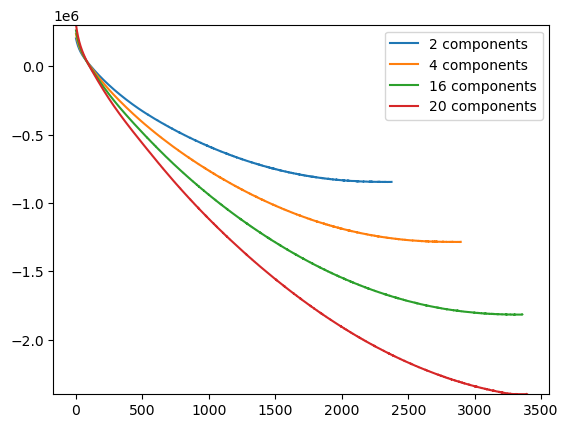

In [297]:
import matplotlib.pyplot as plt

test1 = losses[2][:5000]
test2 = losses[6][:5000]
test3 = losses[16][:5000]
test4 = losses[20][:5000]
ylim_min = min([l for t in [test1, test2, test3, test4] for l in t])
ylim_max = max([l for t in [test1, test2, test3, test4] for l in t])
plt.ylim((ylim_min, ylim_max))
plt.plot(test1, label='2 components')
plt.plot(test2, label='4 components')
plt.plot(test3, label='16 components')
plt.plot(test4, label='20 components')
plt.legend()

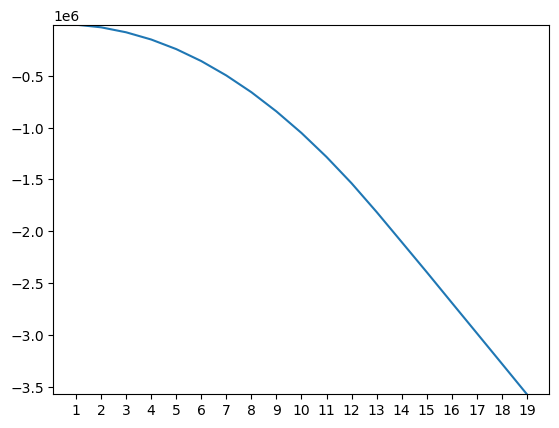

In [298]:
final_losses = [np.mean(l[-200:]) for l in losses.values()]
plt.ylim((min(final_losses),max(final_losses)))
plt.plot(range(1,len(losses)+1), final_losses)
plt.xticks(range(1, len(losses)+1))
plt.show()

We use the component membership probabilities $\boldsymbol\theta$ of each verbframe from our multiview mixed effects mixture model to predict verbs' distributions. Specifically, for verbframe $\langle v, f \rangle$, the membership probability for component $c$ is:

$$
\theta_{\langle v, f\rangle, c} \equiv P\left(z_{\langle v, f \rangle} = c \mid \mathbf{r}_{\langle v, f \rangle}\right) = \frac{P\left(\mathbf{r}_{\langle v, f \rangle} \mid z_{\langle v, f \rangle} = c\right) P\left(z_{\langle v, f \rangle} = c\right)}{\sum_{c} P\left(\mathbf{r}_{\langle v, f \rangle} \mid z_{\langle v, f \rangle} = c\right) P\left(z_{\langle v, f \rangle} = c\right)}
$$

We then aggregate membership probabilities across frames for each verb, i.e., for each verb $v$, we use $\boldsymbol\phi_v$ such that $\phi_{v, c} = 1 - \prod_f 1 - \theta_{\langle v, f\rangle, c}$. 

In [299]:
for n_components, ps in parameters.items():

    component_probs = ps['membership_probs']
    component_probs = component_probs.reset_index()
    component_probs = component_probs.rename(columns = {'index':'verbframe'})
    component_probs[['verb', 'frame']] = component_probs['verbframe'].str.split('-', n=1, expand=True)
    component_probs = component_probs.drop(columns=['verbframe'])

    ps['component_probs'] = component_probs

    component_probs_any = component_probs.pivot_table(index='verb', 
                                                      values=list(range(n_components)),
                                                      aggfunc=lambda x: 1-np.prod(1-x))

    ps['component_probs_any'] = component_probs_any
    
parameters[10]['component_probs_any']

,0,1,2,3,4,5,6,7,8,9
verb,,,,,,,,,,
abhor,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
absolve,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
accept,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
acclaim,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
accredit,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
wow,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
write,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
yearn,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


As our measure of syntactic distribution, we use the normalized version of the [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/) dataset.

In [300]:
ma = pd.read_csv('http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1-normalized.tsv', sep='\t')

ma

,verb,verbform,frame,sentence,responsenorm,responsevar
0,abhor,abhorred,NP Ved,Someone abhorred .,0.937020,-2.288458
1,abhor,abhorred,NP Ved NP,Someone abhorred something .,1.757018,-1.554375
2,abhor,abhorred,NP Ved NP VP,Someone abhorred someone do something .,-1.728826,-1.018119
3,abhor,abhorred,NP Ved NP VPing,Someone abhorred someone doing something .,1.018668,-1.245996
4,abhor,abhorred,NP Ved NP that S,Someone abhorred someone that something happen...,-0.595499,-0.585704
...,...,...,...,...,...,...
50345,refuse,refused,NP was Ved whether S[+future],Someone was refused whether something would ha...,-0.840208,-1.110817
50346,refuse,refused,NP was Ved whether to VP,Someone was refused whether to do something .,-0.522459,-1.057192
50347,refuse,refused,NP was Ved whichNP S,Someone was refused which thing happened .,-1.826966,-0.228580
50348,refuse,refused,NP was Ved whichNP to VP,Someone was refused which thing to do .,-0.682572,-1.059557


In [ ]:
ma_cast = ma.pivot_table(index='verb', columns='frame', values='responsenorm')

ma_cast

frame,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
abhor,0.937020,1.757018,-1.728826,1.018668,-0.595499,-1.710499,-1.373725,-0.151609,-0.970789,-0.575904,...,0.164902,0.284888,0.482186,0.197919,-0.195694,0.337812,0.177505,0.362723,-0.967037,0.135286
absolve,-0.663034,1.145783,-0.666244,-0.186460,-0.113224,-1.373725,-0.096106,-0.640620,-0.300382,-0.155661,...,-0.036710,-0.172364,-0.325584,-0.754879,0.214287,-0.175035,-0.354602,-0.802287,-0.942693,-0.574568
accept,3.408551,2.302293,-0.177098,2.355586,-1.155363,-1.335952,-0.889221,-0.434964,0.722037,0.292264,...,-0.229893,-0.342262,0.718703,0.448758,-0.278486,-0.917158,-0.041599,-0.371269,-0.221968,1.196415
acclaim,0.787558,1.534969,-1.524099,0.749058,-1.574656,-0.819817,-1.679829,1.100519,-0.715073,-0.767939,...,-0.649803,-0.836003,-0.044266,0.803186,-0.600169,-1.289758,-0.567637,-0.471043,-1.909964,-0.218731
accredit,-0.146072,1.021509,-0.688883,0.177532,-1.242959,0.572064,-1.255702,2.689353,-1.051199,0.737418,...,-0.691179,-0.777956,0.756213,0.934650,-0.211424,-0.628762,-0.363196,-0.981960,-1.089276,-0.087709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
write,1.127889,3.158144,1.066073,0.627767,1.993645,1.405902,0.723277,4.265943,0.146673,0.975779,...,-0.972520,-1.075251,-0.019699,0.346763,-0.696586,-0.591181,-0.758885,-2.308244,-0.936538,1.746800
yawn,2.273459,-0.017889,-0.849888,-1.790265,-1.649073,-1.239552,-1.253520,-0.097707,-1.065610,-2.483755,...,-1.120533,-1.761810,-2.628754,-1.628078,-1.822994,-2.293340,-1.727873,-1.553524,-0.717280,0.399846
yearn,1.925214,0.634190,-0.560154,-0.556584,-1.267911,-1.938627,-1.348493,-0.569622,0.695818,-0.860978,...,-0.993025,-0.326606,-1.532523,-1.632808,-1.161706,-1.158492,-0.716224,-1.462843,-1.845160,0.375853


We regress the normalized acceptability for each predicate $v$ in MegaAcceptability on $\boldsymbol\phi_v$s using multivariate ridge regression. To evaluate the performance of this regression on data the model hasn't seen before, we use a separate outer 10-fold cross-validation. We then compute the by-item squared errors.

In [ ]:
np.random.seed(2039486)

errors = defaultdict(list)

ma_cast = ma_cast.sort_values('NP Ved')
ma_cast = ma_cast.sample(frac=1, replace=False)

for i, (n_components, ps) in enumerate(parameters.items()):
    print(f'Fitting models with {n_components} components...')
    
    shared_index = ma_cast.index.intersection(ps['component_probs_any'].index)
    
    X = ps['component_probs_any'].loc[shared_index]
    Y = ma_cast.loc[shared_index]

    total_variance = Y.values.var()
    
    kf = KFold(n_splits=10, shuffle=False)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        mod = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X_train, Y_train)
        Y_test_pred = mod.predict(X_test)
    
        e = np.square(Y_test.to_numpy() - Y_test_pred)
        errors[n_components].append(e.tolist())
    
    errors[n_components] = np.concatenate(errors[n_components], axis=0)
    
    ci = np.quantile([np.mean(np.random.choice(errors[n_components].flatten(), 
                                               size=len(errors[n_components].flatten()), 
                                               replace=True))
                      for _ in range(999)], [0.025/(i+1), 0.5, 1.-0.025/(i+1)])
    
    r2 = np.round(1-ci/total_variance, 3)
    
    print()
    print(f'R2: {r2[1]}, 95%CI = [{r2[2]}, {r2[0]}]')
    print()

Fitting models with 2 components...

R2: 0.232, 95%CI = [0.221, 0.243]

Fitting models with 3 components...

R2: 0.254, 95%CI = [0.241, 0.265]

Fitting models with 4 components...

R2: 0.267, 95%CI = [0.255, 0.279]

Fitting models with 5 components...

R2: 0.28, 95%CI = [0.267, 0.293]

Fitting models with 6 components...

R2: 0.296, 95%CI = [0.284, 0.31]

Fitting models with 7 components...

R2: 0.303, 95%CI = [0.29, 0.316]

Fitting models with 8 components...

R2: 0.301, 95%CI = [0.289, 0.314]

Fitting models with 9 components...

R2: 0.302, 95%CI = [0.288, 0.315]

Fitting models with 10 components...

R2: 0.307, 95%CI = [0.295, 0.32]

Fitting models with 11 components...

R2: 0.306, 95%CI = [0.291, 0.32]

Fitting models with 12 components...

R2: 0.313, 95%CI = [0.298, 0.327]

Fitting models with 13 components...

R2: 0.31, 95%CI = [0.296, 0.325]

Fitting models with 14 components...

R2: 0.316, 95%CI = [0.304, 0.331]

Fitting models with 15 components...

R2: 0.325, 95%CI = [0.31, 0

We then choose the optimal number of clusters as the minimal number of clusters such that no model with a greater number of clusters performs reliably better in terms of by-item squared error.

In [ ]:
curr_n_components = min(errors)
curr_best = True
n_tests = 0

while True:
    for n_components in range(curr_n_components+1, max(errors)+1):
    #for n_components in range(curr_n_components+1, 21):
        diff_mse = errors[n_components] - errors[curr_n_components]

        alpha = 0.025/(n_tests+1)
        
        ci = np.quantile([np.mean(np.random.choice(diff_mse.flatten(), 
                                                   size=len(diff_mse.flatten()),
                                                   replace=True))
                          for _ in range(999)], [alpha, 0.5, 1.-alpha])

        n_tests += 1

        if ci[2] < 0:
            ci = np.round(ci, 3)
            print(f'Model with {n_components} components outperforms '
                  f'model with {curr_n_components} components')
            print(f'Difference in MSE: {ci[1]}, 95%CI=[{ci[0]}, {ci[2]}], alpha={np.round(alpha, 5)}')
            print()
            curr_n_components += 1
            break

    else:
        print()
        print(f'The model with {curr_n_components} components is the optimal model.')
        
        best_n_components = curr_n_components
        best_model = parameters[curr_n_components]
        break      

Model with 3 components outperforms model with 2 components
Difference in MSE: -0.034, 95%CI=[-0.038, -0.03], alpha=0.025

Model with 4 components outperforms model with 3 components
Difference in MSE: -0.022, 95%CI=[-0.028, -0.017], alpha=0.0125

Model with 5 components outperforms model with 4 components
Difference in MSE: -0.02, 95%CI=[-0.026, -0.015], alpha=0.00833

Model with 6 components outperforms model with 5 components
Difference in MSE: -0.027, 95%CI=[-0.035, -0.02], alpha=0.00625

Model with 7 components outperforms model with 6 components
Difference in MSE: -0.011, 95%CI=[-0.017, -0.004], alpha=0.005

Model with 12 components outperforms model with 7 components
Difference in MSE: -0.014, 95%CI=[-0.023, -0.006], alpha=0.0025

Model with 12 components outperforms model with 8 components
Difference in MSE: -0.017, 95%CI=[-0.027, -0.007], alpha=0.00179

Model with 10 components outperforms model with 9 components
Difference in MSE: -0.009, 95%CI=[-0.018, -0.0], alpha=0.00167



To investigate the verb-frame pairs that fall into each cluster, we look at pairs that have probability 1 for that cluster. 

In [ ]:
for i in range(best_n_components):
    print(f'Verbs with highest weight for component {i}')
    print(best_model['membership_probs'][best_model['membership_probs'][i]>=0.9].index)
    print()
    
best_model['membership_probs'].round(decimals=3)

Verbs with highest weight for component 0
Index(['abhor-NP V VPing', 'abhor-NP V that S[+future]',
       'abhor-NP be V that S', 'admonish-NP V VPing',
       'aggravate-NP be V that S[+future]', 'agitate-NP be V that S',
       'agitate-NP be V that S[+future]', 'agitate-NP be V to VP[-eventive]',
       'agonize-NP V VPing', 'agonize-NP be V that S[+future]',
       ...
       'whine-NP V to NP that S', 'whisper-NP V to VP[-eventive]',
       'worry-NP V VPing', 'worry-NP V that S', 'worry-NP V that S[+future]',
       'worry-NP be V that S', 'worry-NP be V that S[+future]',
       'worry-NP be V to VP[-eventive]', 'wow-NP V to VP[+eventive]',
       'yelp-NP V that S'],
      dtype='object', length=401)

Verbs with highest weight for component 1
Index(['advertise-NP V to NP to VP[+eventive]',
       'advise-NP V NP to VP[-eventive]', 'advise-NP V to VP[+eventive]',
       'advocate-NP V VPing', 'afford-NP V for NP to VP',
       'allege-NP be V that S[+future]', 'amaze-NP V that S'

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
abhor-NP V VPing,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP V that S,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP V that S[+future],1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP be V that S,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abhor-NP be V to VP[+eventive],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yelp-NP V for NP to VP,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yelp-NP V that S,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yelp-NP V that S[+future],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yelp-NP V to NP that S,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We label these clusters on the basis of the verb-frame pairs that fall into them and the inference patterns associated with them.

In [ ]:
# TODO vvvvvvvvv

# cluster_labels = {0: 'Negative internal emotives',
#                   1: 'Miratives and antidoxastics',
#                   2: 'Negative emotive communicatives',
#                   3: 'Weak communicatives',
#                   4: 'Strong communicatives',
#                   5: 'Representationals', 
#                   6: 'Deceptives',
#                   7: 'Discourse commitment',
#                   8: 'Negative external emotives',
#                   9: 'Positive external emotives',
#                   10: 'Preferentials',
#                   11: 'Positive internal emotives',
#                   12: 'Future commitment',
#                   13: 'Speculatives',
#                   14: 'Negative emotive miratives'}

cluster_labels = {i: str(i) for i in range(best_n_components)}

# [cluster_labels[i] for i in [11, 9, 0, 8, 14, 2, 10, 1, 6, 3, 4, 7,  12, 13,  5][::-1]]

cluster_order = [cluster_labels[i] for i in list(cluster_labels.keys())]

cluster_order

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16']

Figures 4-6 of the paper plot the means for each cluster relative to each view.

In [ ]:
# Take softmax of thetas and replace dataframes
# TODO: in final version of notebook, should just apply softmax when getting the parameters for each model in the fitting loop

bd_theta_1 = torch.tensor(best_model['belief_desire_theta_1'].to_numpy())
bd_theta_0 = torch.tensor(best_model['belief_desire_theta_0'].to_numpy())
bd_theta_prior = torch.tensor(best_model['belief_desire_theta_prior'].to_numpy())
bd_theta = torch.nn.Softmax(dim=0)(torch.stack((bd_theta_1, bd_theta_0, bd_theta_prior)))

best_model['belief_desire_theta_1'][:] = bd_theta[0].data.numpy()
best_model['belief_desire_theta_0'][:] = bd_theta[1].data.numpy()
best_model['belief_desire_theta_prior'][:] = bd_theta[2].data.numpy()

best_model['belief_desire_value'] = (1 * best_model['belief_desire_theta_1']
                                     + 0 * best_model['belief_desire_theta_0']
                                     + sigmoid(best_model['belief_desire_locs']) * best_model['belief_desire_theta_prior'])

best_model['belief_desire_value']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
negative-object-na-believe,0.568605,0.345770,0.708042,0.708042,0.343867,0.343867,0.362846,0.343875,0.356570,0.343867,0.343914,0.343985,0.343867,0.343867,0.359149,0.343866,0.343867
negative-object-na-want,0.618810,0.350581,0.708042,0.708026,0.343867,0.343867,0.420739,0.343867,0.570551,0.344138,0.706052,0.570182,0.343867,0.343867,0.391014,0.343867,0.344433
negative-object-object-believe,0.707932,0.448378,0.708032,0.367321,0.343893,0.567671,0.343867,0.570377,0.708042,0.343932,0.567216,0.343878,0.344054,0.708042,0.343995,0.343867,0.362912
negative-object-object-intend,0.571442,0.391706,0.667005,0.343892,0.532194,0.501987,0.570522,0.708038,0.708042,0.343867,0.343896,0.344704,0.343867,0.708042,0.343867,0.546286,0.561238
negative-object-object-want,0.708042,0.570552,0.568521,0.359135,0.531944,0.708042,0.344976,0.707742,0.570549,0.568536,0.343876,0.343977,0.343997,0.707687,0.421379,0.707940,0.361361
negative-object-subject-believe,0.343867,0.439124,0.426826,0.343870,0.397740,0.358840,0.437363,0.343867,0.344001,0.415157,0.343879,0.707677,0.343867,0.343867,0.482805,0.343867,0.408361
negative-object-subject-intend,0.504593,0.536768,0.560255,0.345427,0.507237,0.366616,0.489909,0.343867,0.343877,0.484244,0.343866,0.343867,0.381094,0.343879,0.568316,0.570377,0.606504
negative-object-subject-want,0.494423,0.525215,0.513921,0.568257,0.531099,0.456222,0.537306,0.708041,0.345068,0.512186,0.501957,0.705272,0.512793,0.569916,0.527364,0.343867,0.554493
negative-subject-na-believe,0.708042,0.343959,0.708042,0.343867,0.368597,0.343867,0.707971,0.555282,0.708042,0.343867,0.344000,0.682300,0.343867,0.343867,0.708042,0.343867,0.344455
negative-subject-na-want,0.708041,0.343867,0.708040,0.343867,0.343867,0.343867,0.343867,0.343889,0.708042,0.343867,0.343867,0.570528,0.343867,0.343868,0.708042,0.343866,0.343867


In [ ]:
best_belief_desire_locs = best_model['belief_desire_value']

factors = np.array([np.array(x) for x 
                    in best_belief_desire_locs.index.str.split('-', expand=True).values])
best_belief_desire_locs[['polarity', 'target', 'control', 'consequent_verb']] = factors

best_belief_desire_locs['template'] = best_belief_desire_locs.polarity.map({'positive': 'A __ ((to) B)',
                                                                          'negative': 'A not __ ((to) B)'}) + ' ' +\
                                      best_belief_desire_locs.control.map({'subject': 'to VP', 'object': 'to VP',
                                                                           'na': 'that S'}) + ' ~> ' +\
                                      best_belief_desire_locs.target.map({'subject': 'A',
                                                                          'object': 'B'}) + ' ' +\
                                      best_belief_desire_locs.consequent_verb + 's ' +\
                                      best_belief_desire_locs.control.map({'subject': 'A ',
                                                                          'object': 'B ',
                                                                          'na':''}) +\
                                      best_belief_desire_locs.control.map({'subject': 'VP', 'object': 'VP',
                                                                           'na': 'S'})

best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb']), 
                                       id_vars=['polarity', 'template'])

best_belief_desire_locs_melt = best_belief_desire_locs_melt.drop(columns='polarity')

best_belief_desire_locs_melt['label'] = best_belief_desire_locs_melt.variable.map(cluster_labels)
best_belief_desire_locs_melt['inferencetype'] = best_belief_desire_locs_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic' if 'want' in x else 'intention')

best_belief_desire_locs_melt

,template,variable,value,label,inferencetype
0,A not __ ((to) B) that S ~> B believes S,0,0.568605,0,doxastic
1,A not __ ((to) B) that S ~> B wants S,0,0.618810,0,bouletic
2,A not __ ((to) B) to VP ~> B believes B VP,0,0.707932,0,doxastic
3,A not __ ((to) B) to VP ~> B intends B VP,0,0.571442,0,intention
4,A not __ ((to) B) to VP ~> B wants B VP,0,0.708042,0,bouletic
...,...,...,...,...,...
539,A __ ((to) B) to VP ~> A intends B VP,16,0.708042,16,intention
540,A __ ((to) B) to VP ~> A wants B VP,16,0.708042,16,bouletic
541,A __ ((to) B) to VP ~> A believes A VP,16,0.708042,16,doxastic
542,A __ ((to) B) to VP ~> A intends A VP,16,0.708042,16,intention


In [ ]:
best_veridicality_locs = best_model['veridicality_locs']

factors = np.array([np.array(x) for x 
                    in best_veridicality_locs.index.str.split('-', expand=True).values])

best_veridicality_locs['polarity'] = factors
best_veridicality_locs = best_veridicality_locs.explode('polarity')

best_veridicality_locs['template'] = best_veridicality_locs.polarity.map({'positive': 'A __ that/to S/VP',
                                                                         'negative': 'A not __ that/to S/VP'}) + ' ~> S/VP'

best_veridicality_locs_melt = pd.melt(best_veridicality_locs, 
                                       id_vars=['polarity', 'template'])

best_veridicality_locs_melt = best_veridicality_locs_melt.drop(columns="polarity")

veridicality_jumps = parameters[best_n_components]['veridicality_jumps_participant']
veridicality_cuts = veridicality_jumps.cumsum(axis=1) - veridicality_jumps.cumsum(axis=1).mean()

veridicality_cuts_mean = veridicality_cuts.mean(axis=0)

cumprobs = 1/(1+np.exp(-(veridicality_cuts_mean[None,:] - np.array(best_veridicality_locs_melt.value)[:,None])))
probs = np.concatenate([cumprobs[:,[0]], cumprobs[:,[1]] - cumprobs[:,[0]], 1-cumprobs[:,[1]]], axis=1)

best_veridicality_locs_melt['value'] = np.sum(probs*np.array([[0, 0.5, 1.]]), axis=1)
best_veridicality_locs_melt['label'] = best_veridicality_locs_melt.variable.map(cluster_labels)
best_veridicality_locs_melt['inferencetype'] = 'veridicality'

best_veridicality_locs_melt

,template,variable,value,label,inferencetype
0,A not __ that/to S/VP ~> S/VP,0,0.610669,0,veridicality
1,A __ that/to S/VP ~> S/VP,0,0.815890,0,veridicality
2,A not __ that/to S/VP ~> S/VP,1,0.229928,1,veridicality
3,A __ that/to S/VP ~> S/VP,1,0.655790,1,veridicality
4,A not __ that/to S/VP ~> S/VP,2,0.462900,2,veridicality
5,A __ that/to S/VP ~> S/VP,2,0.739667,2,veridicality
6,A not __ that/to S/VP ~> S/VP,3,0.239757,3,veridicality
7,A __ that/to S/VP ~> S/VP,3,0.457637,3,veridicality
8,A not __ that/to S/VP ~> S/VP,4,0.326105,4,veridicality
9,A __ that/to S/VP ~> S/VP,4,0.722186,4,veridicality


In [ ]:
# Take softmax of thetas and replace dataframes
# TODO: in final version of notebook, should just apply softmax when getting the parameters for each model in the fitting loop

nr_theta_1 = torch.tensor(best_model['negraising_theta_1'].to_numpy())
nr_theta_0 = torch.tensor(best_model['negraising_theta_0'].to_numpy())
nr_theta_prior = torch.tensor(best_model['negraising_theta_prior'].to_numpy())
nr_theta = torch.nn.Softmax(dim=0)(torch.stack((nr_theta_1, nr_theta_0, nr_theta_prior)))

best_model['negraising_theta_1'][:] = nr_theta[0].data.numpy()
best_model['negraising_theta_0'][:] = nr_theta[1].data.numpy()
best_model['negraising_theta_prior'][:] = nr_theta[2].data.numpy()

best_model['negraising_value'] = (1 * best_model['negraising_theta_1']
                                  + 0 * best_model['negraising_theta_0']
                                  + sigmoid(best_model['negraising_locs']) * best_model['negraising_theta_prior'])

best_model['negraising_value']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
first-past,0.343867,0.708042,0.344794,0.707855,0.344002,0.569614,0.355304,0.343867,0.344861,0.515364,0.343869,0.343868,0.688205,0.343890,0.343874,0.478812,0.514168
first-present,0.357556,0.708042,0.570475,0.643932,0.436010,0.344700,0.358062,0.343867,0.345555,0.442291,0.343867,0.343869,0.706976,0.350833,0.344941,0.343867,0.687763
third-past,0.344127,0.708042,0.343867,0.707990,0.344353,0.347120,0.343870,0.346529,0.343903,0.570549,0.344964,0.345332,0.708032,0.343869,0.351224,0.343880,0.437645
third-present,0.344033,0.708042,0.346685,0.708041,0.439236,0.344810,0.344504,0.343884,0.344359,0.700044,0.421053,0.344558,0.707840,0.433978,0.343924,0.343991,0.665637


In [ ]:
best_negraising_locs = best_model['negraising_value']

factors = np.array([np.array(x) for x 
                    in best_negraising_locs.index.str.split('-', expand=True).values])
best_negraising_locs[['person', 'tense']] = factors

best_negraising_locs['template'] = best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' not ' +\
                                   best_negraising_locs.tense.map({'past': '__[past]', 'present': '__[pres]'}) + ' ' +\
                                   'S ~> ' +\
                                   best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                   best_negraising_locs.tense.map({'past': '__[past]', 'present': '__[pres]'}) + ' ' +\
                                   'not S'

best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense']), 
                                       id_vars='template')

best_negraising_locs_melt['label'] = best_negraising_locs_melt.variable.map(cluster_labels)

best_negraising_locs_melt['inferencetype'] = 'negraising'

best_negraising_locs_melt

,template,variable,value,label,inferencetype
0,A[1s] not __[past] S ~> A[1s] __[past] not S,0,0.343867,0,negraising
1,A[1s] not __[pres] S ~> A[1s] __[pres] not S,0,0.357556,0,negraising
2,A[3s] not __[past] S ~> A[3s] __[past] not S,0,0.344127,0,negraising
3,A[3s] not __[pres] S ~> A[3s] __[pres] not S,0,0.344033,0,negraising
4,A[1s] not __[past] S ~> A[1s] __[past] not S,1,0.708042,1,negraising
...,...,...,...,...,...
63,A[3s] not __[pres] S ~> A[3s] __[pres] not S,15,0.343991,15,negraising
64,A[1s] not __[past] S ~> A[1s] __[past] not S,16,0.514168,16,negraising
65,A[1s] not __[pres] S ~> A[1s] __[pres] not S,16,0.687763,16,negraising
66,A[3s] not __[past] S ~> A[3s] __[past] not S,16,0.437645,16,negraising


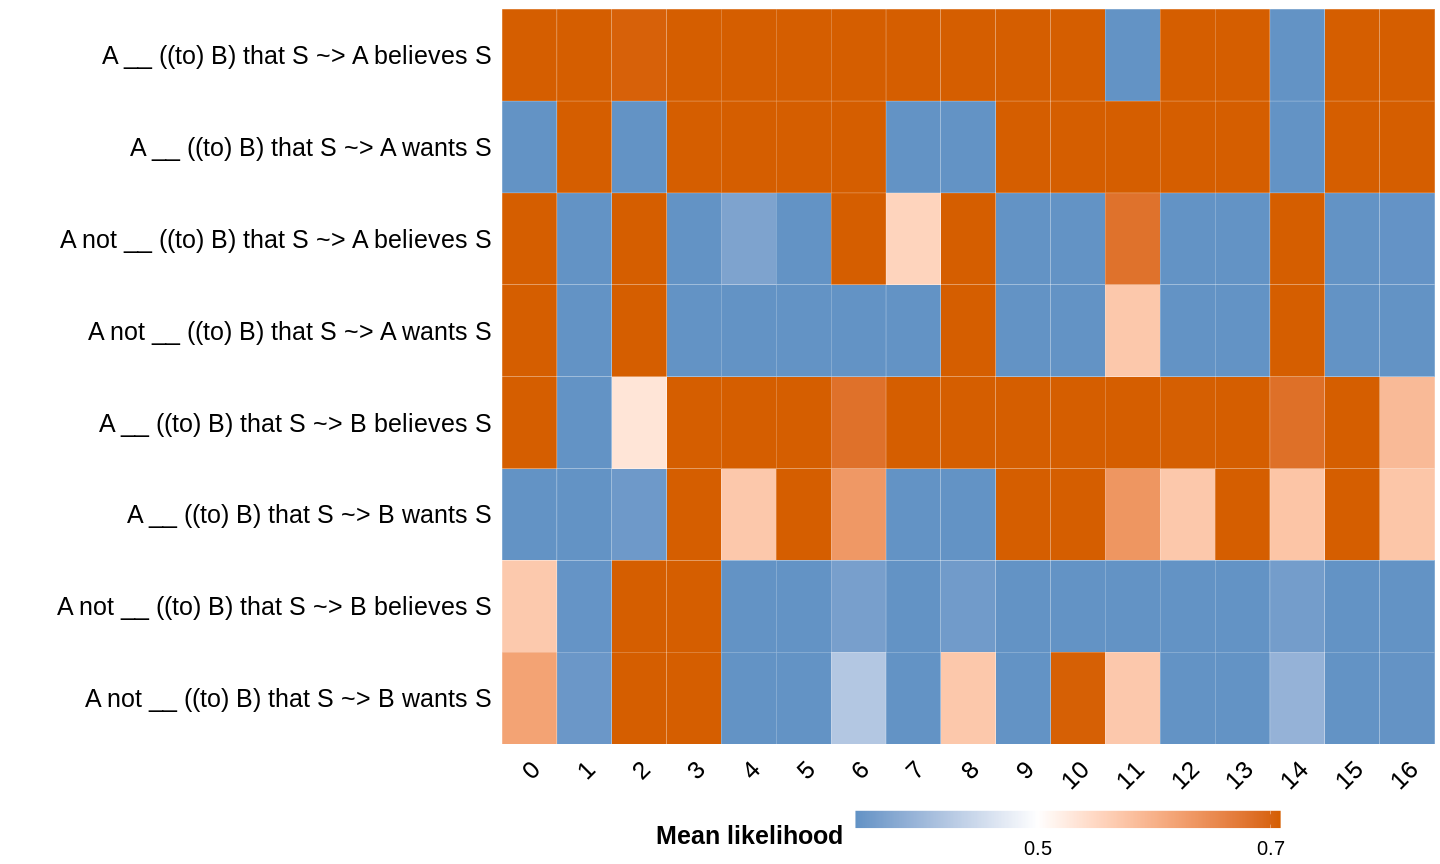

In [ ]:
%%R -i best_belief_desire_locs_melt -i cluster_order -w 20 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

belief_desire_template_order_f = rev(c('A __ ((to) B) that S ~> A believes S',
                                       'A __ ((to) B) that S ~> A wants S',
                                       'A not __ ((to) B) that S ~> A believes S',
                                       'A not __ ((to) B) that S ~> A wants S',
                                       'A __ ((to) B) that S ~> B believes S',
                                       'A __ ((to) B) that S ~> B wants S',
                                       'A not __ ((to) B) that S ~> B believes S',
                                       'A not __ ((to) B) that S ~> B wants S'))

best_belief_desire_locs_melt <- filter(best_belief_desire_locs_melt, template%in%belief_desire_template_order_f)
best_belief_desire_locs_melt$template <- ordered(best_belief_desire_locs_melt$template,
                                                levels=belief_desire_template_order_f)

# cluster_order = c('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19')

best_belief_desire_locs_melt$label <- ordered(best_belief_desire_locs_melt$label,
                                                levels=cluster_order)


g = ggplot(best_belief_desire_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/finite_belief_desire-loadings-15.pdf', width=20, height=12)
ggsave('plots/finite_belief_desire-loadings-15.png', width=20, height=12)

g

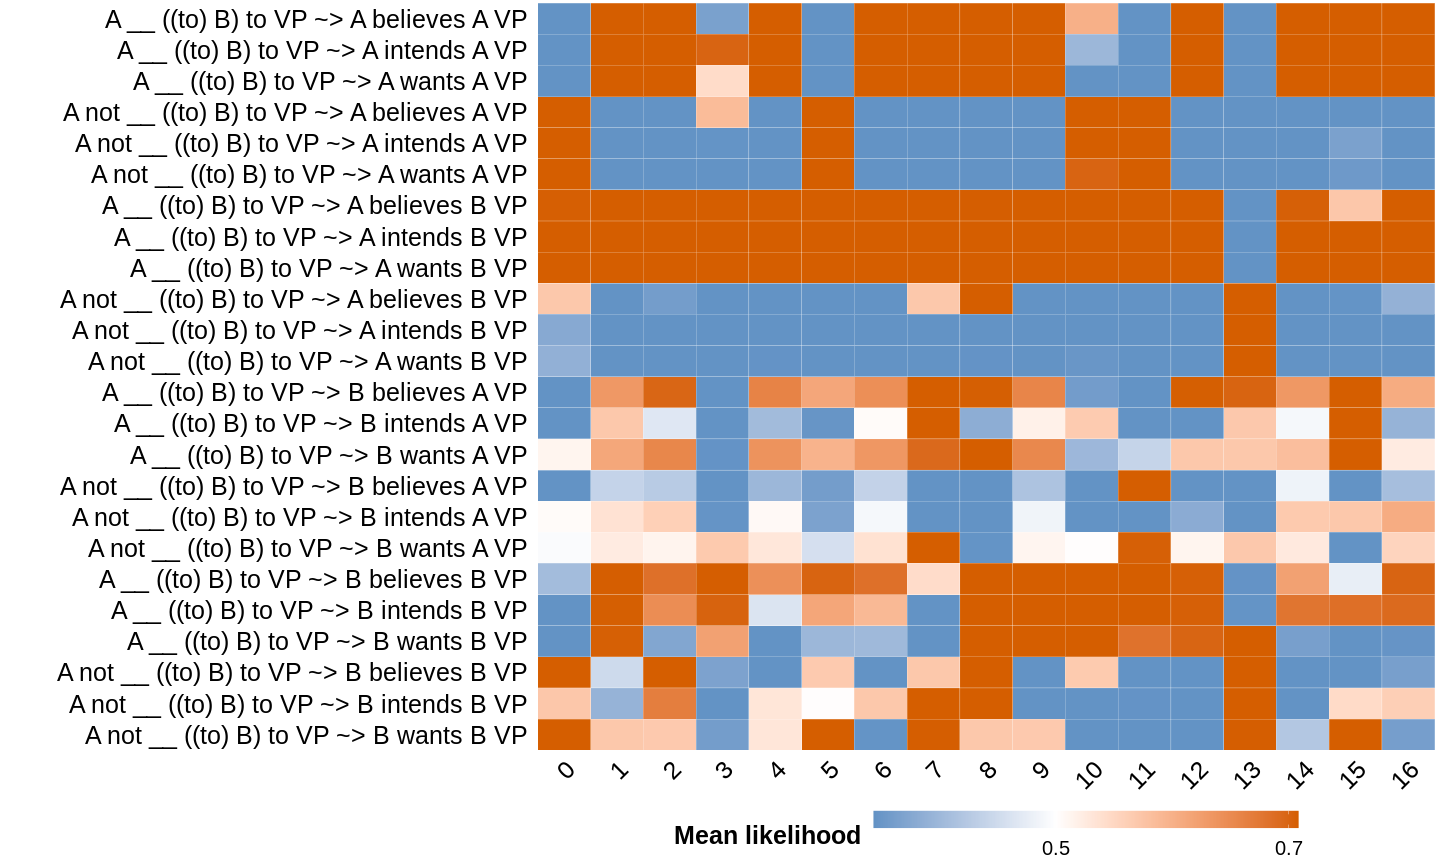

In [ ]:
%%R -i best_belief_desire_locs_melt -i cluster_order -w 20 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

belief_desire_template_order_nf = rev(c('A __ ((to) B) to VP ~> A believes A VP',
                                        'A __ ((to) B) to VP ~> A intends A VP',
                                        'A __ ((to) B) to VP ~> A wants A VP',
                                        'A not __ ((to) B) to VP ~> A believes A VP',
                                        'A not __ ((to) B) to VP ~> A intends A VP',
                                        'A not __ ((to) B) to VP ~> A wants A VP',
                                        'A __ ((to) B) to VP ~> A believes B VP',
                                        'A __ ((to) B) to VP ~> A intends B VP',
                                        'A __ ((to) B) to VP ~> A wants B VP',
                                        'A not __ ((to) B) to VP ~> A believes B VP',
                                        'A not __ ((to) B) to VP ~> A intends B VP',
                                        'A not __ ((to) B) to VP ~> A wants B VP',
                                        'A __ ((to) B) to VP ~> B believes A VP',
                                        'A __ ((to) B) to VP ~> B intends A VP',
                                        'A __ ((to) B) to VP ~> B wants A VP',
                                        'A not __ ((to) B) to VP ~> B believes A VP',
                                        'A not __ ((to) B) to VP ~> B intends A VP',
                                        'A not __ ((to) B) to VP ~> B wants A VP',
                                        'A __ ((to) B) to VP ~> B believes B VP',
                                        'A __ ((to) B) to VP ~> B intends B VP',
                                        'A __ ((to) B) to VP ~> B wants B VP',
                                        'A not __ ((to) B) to VP ~> B believes B VP',
                                        'A not __ ((to) B) to VP ~> B intends B VP',
                                        'A not __ ((to) B) to VP ~> B wants B VP'))

best_belief_desire_locs_melt <- filter(best_belief_desire_locs_melt, template%in%belief_desire_template_order_nf)
best_belief_desire_locs_melt$template <- ordered(best_belief_desire_locs_melt$template,
                                                levels=belief_desire_template_order_nf)

best_belief_desire_locs_melt$label <- ordered(best_belief_desire_locs_melt$label,
                                                levels=cluster_order)


g = ggplot(best_belief_desire_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/nonfinite_belief_desire-loadings-15.pdf', width=20, height=12)
ggsave('plots/nonfinite_belief_desire-loadings-15.png', width=20, height=12)

g

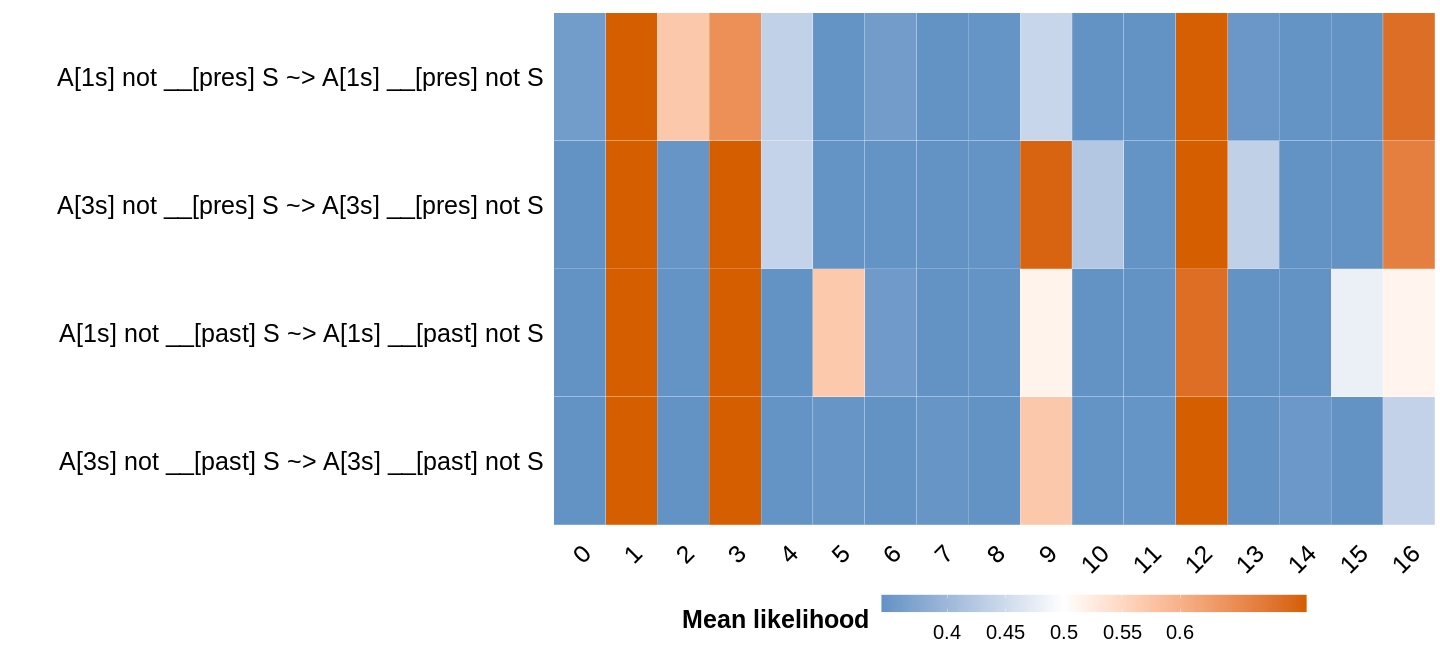

In [ ]:
%%R -i best_negraising_locs_melt -i cluster_order -w 20 -h 9 -u in

library(tidyverse)

theme_set(theme_bw())

negraising_template_order = rev(c('A[1s] not __[pres] S ~> A[1s] __[pres] not S',
                                  'A[3s] not __[pres] S ~> A[3s] __[pres] not S',
                                  'A[1s] not __[past] S ~> A[1s] __[past] not S',
                                  'A[3s] not __[past] S ~> A[3s] __[past] not S'))

best_negraising_locs_melt$template <- ordered(best_negraising_locs_melt$template,
                                              levels=negraising_template_order)

best_negraising_locs_melt$label <- ordered(best_negraising_locs_melt$label,
                                           levels=cluster_order)

g = ggplot(best_negraising_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.1, -0.05, 0, 0.05, 0.1),
                     labels=c(-0.1, -0.05, 0, 0.05, 0.1)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/negraising-loadings-15.pdf', width=20, height=9)
ggsave('plots/negraising-loadings-15.png', width=20, height=9)

g

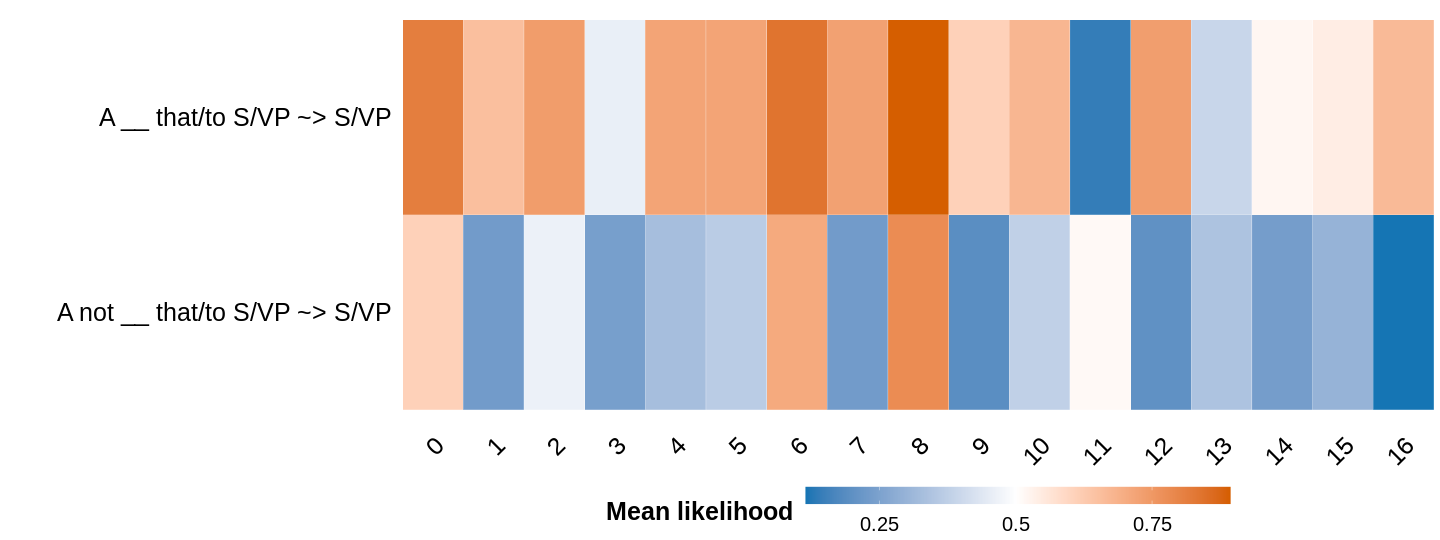

In [ ]:
%%R -i best_veridicality_locs_melt -i cluster_order -w 20 -h 7.5 -u in

library(tidyverse)

theme_set(theme_bw())

veridicality_template_order = rev(c('A __ that/to S/VP ~> S/VP', 'A not __ that/to S/VP ~> S/VP'))

best_veridicality_locs_melt$template <- ordered(best_veridicality_locs_melt$template, 
                                                 levels=veridicality_template_order)

best_veridicality_locs_melt$label <- ordered(best_veridicality_locs_melt$label,
                                             levels=cluster_order)

g = ggplot(best_veridicality_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/veridicality-loadings-15.png', width=20, height=7.5)
ggsave('plots/veridicality-loadings-15.pdf', width=20, height=7.5)

g

To determine a set of generalizations about these clusters, we apply principal component analysis (PCA) to the parameters of the property-specific probability distributions for each cluster.

In [ ]:
all_locs_melt = pd.concat([best_veridicality_locs_melt,
                           best_negraising_locs_melt,
                           best_belief_desire_locs_melt])

all_locs = all_locs_melt.pivot_table(index='label', columns='template', values='value')

all_locs

template,A __ ((to) B) that S ~> A believes S,A __ ((to) B) that S ~> A wants S,A __ ((to) B) that S ~> B believes S,A __ ((to) B) that S ~> B wants S,A __ ((to) B) to VP ~> A believes A VP,A __ ((to) B) to VP ~> A believes B VP,A __ ((to) B) to VP ~> A intends A VP,A __ ((to) B) to VP ~> A intends B VP,A __ ((to) B) to VP ~> A wants A VP,A __ ((to) B) to VP ~> A wants B VP,...,A not __ ((to) B) to VP ~> B believes B VP,A not __ ((to) B) to VP ~> B intends A VP,A not __ ((to) B) to VP ~> B intends B VP,A not __ ((to) B) to VP ~> B wants A VP,A not __ ((to) B) to VP ~> B wants B VP,A not __ that/to S/VP ~> S/VP,A[1s] not __[past] S ~> A[1s] __[past] not S,A[1s] not __[pres] S ~> A[1s] __[pres] not S,A[3s] not __[past] S ~> A[3s] __[past] not S,A[3s] not __[pres] S ~> A[3s] __[pres] not S
label,,,,,,,,,,,,,,,,,,,,,
0,0.708028,0.343867,0.708006,0.343867,0.343877,0.706536,0.343867,0.708042,0.343867,0.708039,...,0.707932,0.504593,0.571442,0.494423,0.708042,0.610669,0.343867,0.357556,0.344127,0.344033
1,0.708043,0.708042,0.343879,0.343867,0.708042,0.708042,0.708042,0.708042,0.708042,0.708042,...,0.448378,0.536768,0.391706,0.525215,0.570552,0.229928,0.708042,0.708042,0.708042,0.708042
10,0.708042,0.708042,0.708042,0.708042,0.601718,0.708041,0.397458,0.708042,0.343867,0.708042,...,0.567216,0.343866,0.343896,0.501957,0.343876,0.376007,0.343869,0.343867,0.344964,0.421053
11,0.343867,0.707940,0.708021,0.635952,0.343868,0.708042,0.343891,0.708042,0.343867,0.708042,...,0.343878,0.343867,0.344704,0.705272,0.343977,0.514276,0.343868,0.343869,0.345332,0.344558
12,0.708042,0.708042,0.707007,0.570623,0.708042,0.708042,0.708042,0.708042,0.708042,0.708041,...,0.344054,0.381094,0.343867,0.512793,0.343997,0.200767,0.688205,0.706976,0.708032,0.707840
13,0.708042,0.708042,0.708042,0.708041,0.343867,0.344138,0.343867,0.343867,0.343877,0.343867,...,0.708042,0.343879,0.708042,0.569916,0.707687,0.339823,0.343890,0.350833,0.343869,0.433978
14,0.343867,0.343867,0.685163,0.574824,0.708042,0.705217,0.708042,0.708028,0.708042,0.708033,...,0.343995,0.568316,0.343867,0.527364,0.421379,0.235532,0.343874,0.344941,0.351224,0.343924
15,0.708042,0.708042,0.708043,0.708042,0.708034,0.571298,0.708042,0.708040,0.708032,0.708042,...,0.343867,0.570377,0.546286,0.343867,0.707940,0.295463,0.478812,0.343867,0.343880,0.343991
16,0.708042,0.708041,0.588348,0.573657,0.708042,0.708042,0.708042,0.708042,0.708042,0.708042,...,0.362912,0.606504,0.561238,0.554493,0.361361,0.114938,0.514168,0.687763,0.437645,0.665637


In [ ]:
pca = PCA().fit(all_locs.apply(lambda x: (x-x.mean())/x.std(), axis=0))

pca_components = pd.DataFrame(pca.components_, columns=all_locs.columns)

pca_components_melt = pd.melt(pca_components.T.reset_index(), id_vars="template")

pca_components_melt

,template,variable,value
0,A __ ((to) B) that S ~> A believes S,0,-0.014524
1,A __ ((to) B) that S ~> A wants S,0,-0.082460
2,A __ ((to) B) that S ~> B believes S,0,0.133152
3,A __ ((to) B) that S ~> B wants S,0,0.005821
4,A __ ((to) B) to VP ~> A believes A VP,0,-0.207481
...,...,...,...
641,A not __ that/to S/VP ~> S/VP,16,0.002301
642,A[1s] not __[past] S ~> A[1s] __[past] not S,16,0.136414
643,A[1s] not __[pres] S ~> A[1s] __[pres] not S,16,-0.183874
644,A[3s] not __[past] S ~> A[3s] __[past] not S,16,-0.018448


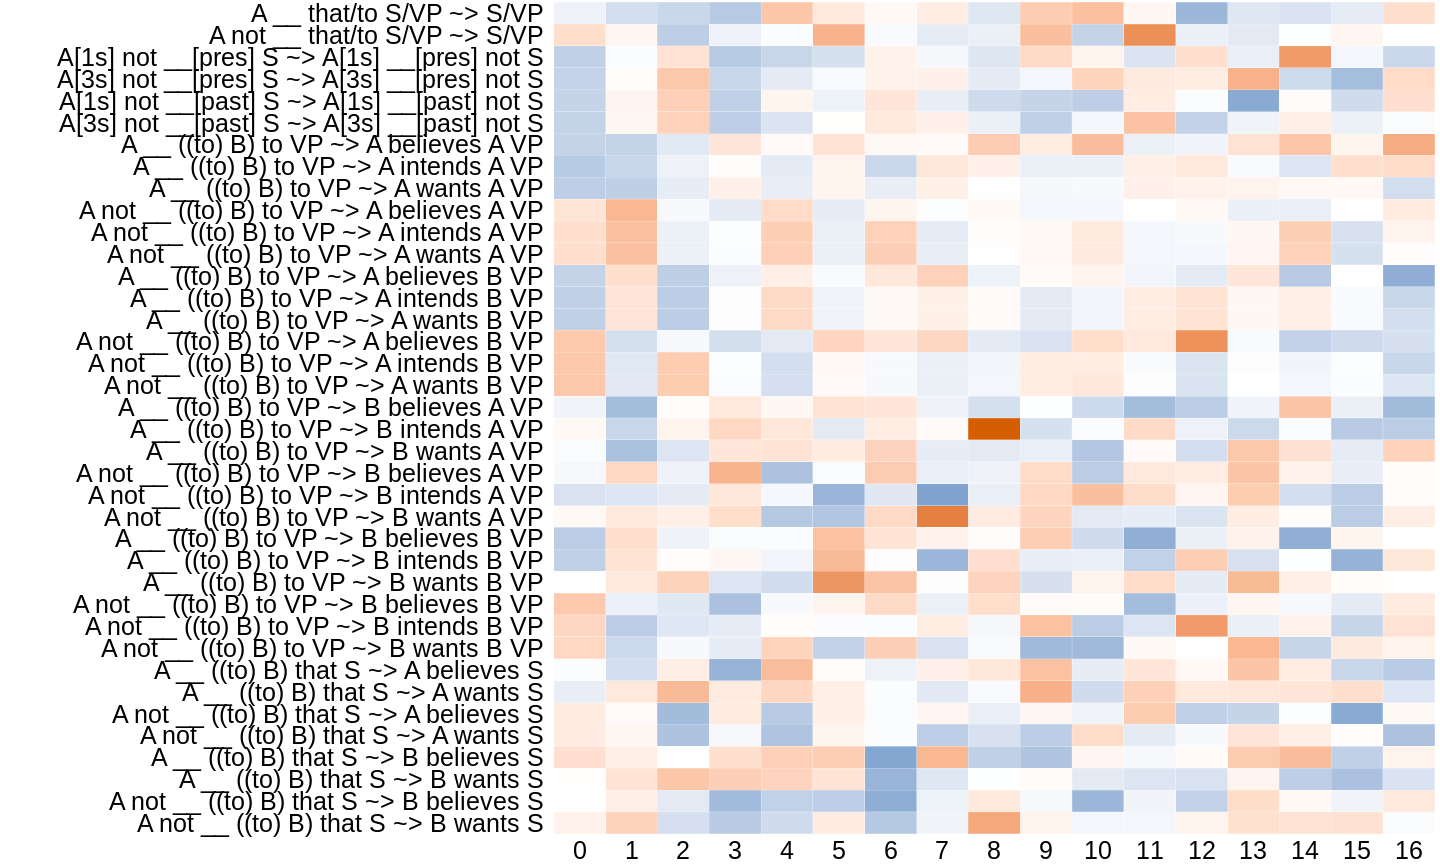

In [ ]:
%%R -i pca_components_melt -w 20 -h 12 -u in

belief_desire_template_order = append(belief_desire_template_order_f, belief_desire_template_order_nf)
pca_components_melt$template = ordered(pca_components_melt$template,
                                      levels=c(belief_desire_template_order,
                                               negraising_template_order,
                                              veridicality_template_order))

g = ggplot(pca_components_melt, aes(y=template, x=as.factor(variable), fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/pca-loadings-15.png', width=20, height=12)
ggsave('plots/pca-loadings-15.pdf', width=20, height=12)

g

Finally, to visualize the relationship between each cluster and the syntax, we plot the coefficients of the best regression mapping clusters to syntax.

In [ ]:
ma_cast_cats = pd.merge(ma_cast, best_model['component_probs_any'], 
                        left_index=True, right_index=True)

component_cols = list(range(best_n_components))

X = ma_cast_cats[component_cols]
Y = ma_cast_cats.drop(columns=component_cols)

best_regression = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X, Y)

In [ ]:
best_regression_coefs = pd.DataFrame(best_regression.coef_, 
                                     index=ma_cast.columns, 
                                     columns=best_model['component_probs_any'].columns)

best_regression_coefs_melt = pd.melt(best_regression_coefs.reset_index(), id_vars='frame')

best_regression_coefs_melt['label'] = best_regression_coefs_melt.variable.map(cluster_labels)

best_regression_coefs_melt

,frame,variable,value,label
0,NP Ved,0,-0.093193,0
1,NP Ved NP,0,-0.354618,0
2,NP Ved NP VP,0,0.082845,0
3,NP Ved NP VPing,0,-0.052341,0
4,NP Ved NP that S,0,0.357583,0
...,...,...,...,...
845,NP was Ved whether S[+future],16,-0.065543,16
846,NP was Ved whether to VP,16,0.123994,16
847,NP was Ved whichNP S,16,-0.076635,16
848,NP was Ved whichNP to VP,16,0.043497,16


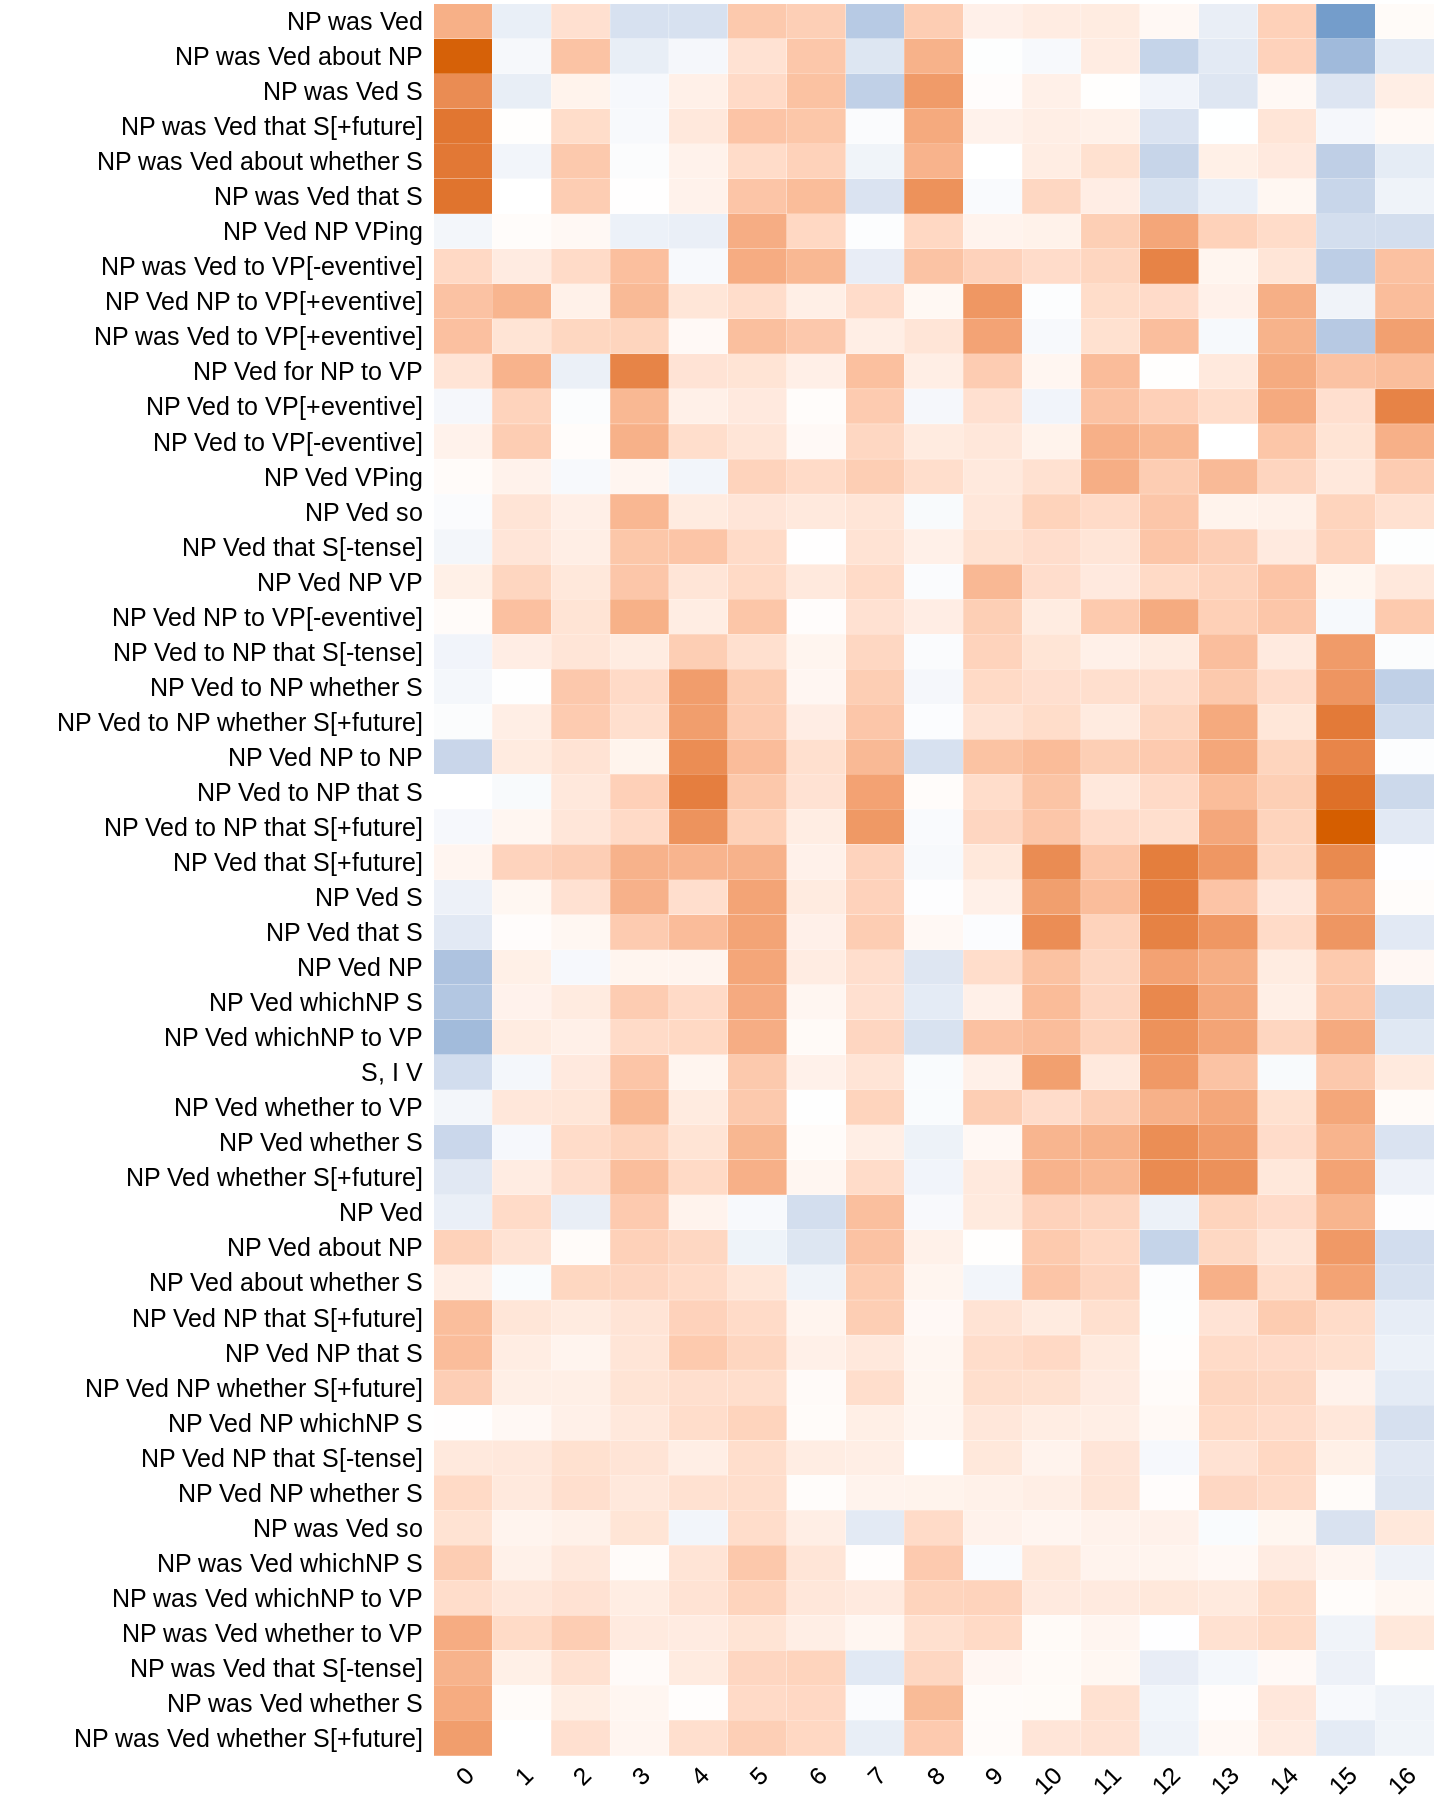

In [ ]:
%%R -i best_regression_coefs -i best_regression_coefs_melt -i cluster_order -w 20 -h 25 -u in

best_regression_coefs_melt$label = ordered(best_regression_coefs_melt$label,
                                      levels=cluster_order)

frame_order = row.names(best_regression_coefs)[rev(hclust(dist(best_regression_coefs))$order)]

best_regression_coefs_melt$frame = ordered(best_regression_coefs_melt$frame,
                                      levels=frame_order)

g = ggplot(best_regression_coefs_melt, aes(y=frame, x=label, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      axis.text.x=element_text(angle=45, hjust=1),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/regression-coefs-15.png', width=20, height=25)
ggsave('plots/regression-coefs-15.pdf', width=20, height=25)

g